In [2]:
from os import listdir
import pickle
import math
import random

import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product

from rdkit import Chem
from rdkit.Chem import ChemicalFeatures, MolFromSmiles, MolToSmiles, AllChem
from rdkit import Geometry
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.RDPaths import RDDataDir
import os.path

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon as jsd
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
%matplotlib inline

fdefFile = os.path.join(RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefFile)

with open('all_ligands.list', 'rb') as pickle_file:
    frags = pickle.load(pickle_file)
# with open('hits_new.list', 'rb') as pickle_file:
#     hits = pickle.load(pickle_file)   
# with open('hits_may.list', 'rb') as pickle_file:
#     hits = pickle.load(pickle_file)   

In [2]:
# hits_df = pd.read_csv('data/activity_data-2.csv')
# hits_df['acrylamide'] = hits_df['acrylamide'].astype(bool)
# hits_df['chloroacetamide'] = hits_df['chloroacetamide'].astype(bool)
# hits_df = hits_df[~hits_df['acrylamide']]
# hits_df = hits_df[~hits_df['chloroacetamide']]

# hit_mols = [None]*len(hits_df)
# activity_list = [None]*len(hits_df)
# for i,row in tqdm(hits_df.iterrows(), total=len(hits_df)):
#     try:
#         mol = MolFromSmiles(row['SMILES'])

#         #constrained conformer generation
#         mol = Chem.AddHs(mol)
#         AllChem.EmbedMolecule(mol)

#         mol = Chem.RemoveHs(mol)

#         #calculate properties from surviving conformers
#         conf = mol.GetConformer()

#         mol_data = [mol]
#         for j,atom in enumerate(mol.GetAtoms()):
#             mol_data.append([atom.GetSymbol(),
#                                 conf.GetPositions()[j]
#                                 ])
#         hit_mols[i] = mol_data
#         if row['f_avg_IC50']<5:
#             activity_list[i]=True
#         else:
#             activity_list[i]=False
#     except:
#         print(str(i)+' failed')
#         continue
# activity_list = [i for i in activity_list if i is not None]
# hit_mols = [i for i in hit_mols if i is not None]

In [27]:
df = pd.read_csv('data/activity_data-3.csv').sort_values(by='f_avg_IC50')
df = df[df['f_avg_IC50']>3]

hits = []
for i,row in df.iterrows():
    hits.append([MolFromSmiles(row['SMILES'])])
        

hit_mols = [None]*len(hits)
for i,hit in tqdm(enumerate(hits), total=len(hits)):
    try:
        mol = MolFromSmiles(MolToSmiles(hit[0]))

        #constrained conformer generation
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)

        mol = Chem.RemoveHs(mol)

        #calculate properties from surviving conformers
        conf = mol.GetConformer()

        mol_data = [mol]
        for j,atom in enumerate(mol.GetAtoms()):
            mol_data.append([atom.GetSymbol(),
                                conf.GetPositions()[j]
                                ])
        hit_mols[i] = mol_data
    except Exception as ex:
        print(ex)
        print(str(i)+' failed')
        continue

100%|██████████| 933/933 [00:50<00:00, 18.35it/s]


In [9]:
print(df['f_avg_IC50'].head())

874     0.030060
421     0.040549
1171    0.050000
216     0.050000
217     0.050000
Name: f_avg_IC50, dtype: float64


In [10]:
from frag_funcs import return_random_dataframe, return_pcore_dataframe, get_pair_distances, get_trip_distances

with open('frag_pair_distance_dict.pickle', 'rb') as handle:
    frag_pair_distance_dict = pickle.load(handle)
with open('frag_trip_distance_dict.pickle', 'rb') as handle:
    frag_trip_distance_dict = pickle.load(handle)
    
with open('hit_pairs.pickle', 'rb') as handle:
    hit_pairs = pickle.load(handle)
# with open('hit_trips.pickle', 'rb') as handle:
#     hit_trips = pickle.load(handle)

In [28]:
interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']

hit_df = return_pcore_dataframe(hit_mols, interesting_pcores, hit=False)

hit_pairs = [None]*len(set(hit_df['mol_id']))
for j,i in tqdm(enumerate(set(hit_df['mol_id'])), total=len(hit_pairs)):
    hit_pair_individual = {}
    
    for pcore_pair in product(interesting_pcores,repeat=2):
        core_a,core_b = pcore_pair
        combo = core_a+'-'+core_b
        hit_pair_individual[combo]= get_pair_distances(hit_df[hit_df['mol_id']==i], core_a, core_b, frag=False, active=None)
    hit_pairs[j] = hit_pair_individual
    
# hit_trips = [None]*len(set(hit_df['mol_id']))
# for j,i in tqdm(enumerate(set(hit_df['mol_id'])), total=len(hit_trips)):
#     hit_trip_individual = {}
#     for pcore_trip in product(interesting_pcores,repeat=3):
#         core_a,core_b,core_c = pcore_trip
#         combo = core_a+'-'+core_b+'-'+core_c
#         hit_trip_individual[combo]= get_trip_distances(hit_df[hit_df['mol_id']==i], core_a, core_b, core_c, frag=False, active=None)
#     hit_trips[j] = hit_trip_individual

100%|██████████| 933/933 [00:33<00:00, 27.92it/s]


In [6]:
### Generate random ZINC conformer 26/02/2021
import random 

# zinc_smi = pd.read_csv(zinc_dir+'/zinc_subset.smi', delim_whitespace=True)['smiles'].values
zinc_smi = pd.read_csv('/rds-d2/user/wjm41/hpc-work/datasets/ZINC/zinc_250k.csv')['smiles'].values

rand_smi = random.sample(list(zinc_smi), k=2000)

zinc_mols = [None]*len(rand_smi)
for i,smi in tqdm(enumerate(rand_smi), total=len(rand_smi)):
    try:
        mol = MolFromSmiles(smi)

        #constrained conformer generation
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)

        mol = Chem.RemoveHs(mol)

        #calculate properties from surviving conformers
        conf = mol.GetConformer()

        mol_data = [mol]
        for j,atom in enumerate(mol.GetAtoms()):
            mol_data.append([atom.GetSymbol(),
                                conf.GetPositions()[j]
                                ])
        zinc_mols[i] = mol_data
    except:
        print(str(i)+' failed')
        continue

print('Number of sampled molecules :{}'.format(len(zinc_mols)))

 59%|█████▊    | 1174/2000 [00:57<01:05, 12.59it/s]

1171 failed


100%|██████████| 2000/2000 [01:33<00:00, 21.44it/s]

Number of sampled molecules :2000


In [7]:
interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']


hitpcore_df = return_pcore_dataframe(hits, interesting_pcores, hit=True)
    
activity_list = [None]*len(set(hitpcore_df['mol_id']))
IC50_list = [None]*len(set(hitpcore_df['mol_id']))

for i in tqdm(set(hitpcore_df['mol_id'])):
    activity_list[i] = hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['active']
    IC50_list[i] = hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['IC50']

100%|██████████| 141/141 [00:00<00:00, 790.84it/s]


In [72]:
print(len(activity_list) == len(hit_pairs))
print(list(map(int, activity_list)))

True
[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# hitpcore_df = return_pcore_dataframe(hits, interesting_pcores, hit=True)
    
# hit_pairs = [None]*len(hitpcore_df['mol_id'])
# for i in tqdm(hitpcore_df['mol_id']):
#     hit_pair_individual = {}
#     for pcore_pair in product(interesting_pcores,repeat=2):
#         core_a,core_b = pcore_pair
#         combo = core_a+'-'+core_b
#         hit_pair_individual[combo]= get_pair_distances(hitpcore_df[hitpcore_df['mol_id']==i], core_a, core_b, frag=False, active=None)
#     hit_pairs[i] = hit_pair_individual
    
# hit_trips = [None]*len(set(hitpcore_df['mol_id']))
# for i in tqdm(set(hitpcore_df['mol_id'])):
#     hit_trip_individual = {}
#     for pcore_trip in product(interesting_pcores,repeat=3):
#         core_a,core_b,core_c = pcore_trip
#         combo = core_a+'-'+core_b+'-'+core_c
#         hit_trip_individual[combo]= get_trip_distances(hitpcore_df[hitpcore_df['mol_id']==i], core_a, core_b, core_c, frag=False, active=None)
#     hit_trips[i] = hit_trip_individual
    
# with open('hit_pairs.pickle', 'wb') as handle:
#     pickle.dump(hit_pairs, handle)        
# with open('hit_trips.pickle', 'wb') as handle:
#     pickle.dump(hit_trips, handle)     

In [8]:
zinc_mols = [ i for i in zinc_mols if i is not None]

interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']

important = ['Donor-Aromatic',
            'Aromatic-Acceptor',
            'Aromatic-Aromatic']
unimportant = ['Donor-Donor',
               'Donor-Acceptor',
               'Acceptor-Acceptor']

pairs = important+unimportant
zinccore_df = return_pcore_dataframe(zinc_mols, interesting_pcores, hit=False)

zinc_pairs = [None]*len(set(zinccore_df['mol_id']))
for j,i in tqdm(enumerate(set(zinccore_df['mol_id'])), total=len(zinc_pairs)):
    zinc_pair_individual = {}
    
    for combo in pairs:
        core_a,core_b = combo.split('-')
        zinc_pair_individual[combo]= get_pair_distances(zinccore_df[zinccore_df['mol_id']==i], core_a, core_b, frag=False, active=None)
    zinc_pairs[j] = zinc_pair_individual
    
# zinc_trips = [None]*len(set(zinccore_df['mol_id']))
# for j,i in tqdm(enumerate(set(zinccore_df['mol_id'])), total=len(zinc_trips)):
#     zinc_trip_individual = {}
#     for pcore_trip in product(interesting_pcores,repeat=3):
#         core_a,core_b,core_c = pcore_trip
#         combo = core_a+'-'+core_b+'-'+core_c
#         zinc_trip_individual[combo]= get_trip_distances(zinccore_df[zinccore_df['mol_id']==i], core_a, core_b, core_c, frag=False, active=None)
#     zinc_trips[j] = zinc_trip_individual

100%|██████████| 1999/1999 [00:46<00:00, 42.99it/s]


## Score hits based on fragment histograms

### Pair Histogram Scoring

In [13]:
def enrichment(score_df, n=10, score='score', index='active', log=False, ascending=True):
    
    df = score_df[score_df[score].notna()]
    orig_prop = len(df[df[index]])/len(df)
    if log:
        print('orig proportion of {}: {:.3f}%'.format(index, orig_prop*100))
    
    sorted_df = df.sort_values(by=score, ascending=ascending).iloc[:n]
    new_prop = len(sorted_df[sorted_df[index]])/len(sorted_df)
    if log:
        print('N = {}, n_hits = {}, new proportion of {}: {:.3f}%'.format(n, len(sorted_df[sorted_df[index]]),index, new_prop*100))
    EF = new_prop/orig_prop
    return EF

# with open('kde_dict.pickle', 'rb') as handle:
#     kde_dict = pickle.load(handle)
with open('kde_dict_opt.pickle', 'rb') as handle:
    kde_dict = pickle.load(handle)
with open('rand_kde_dicts.pickle', 'rb') as pickle_file:
    rand_kde_dicts = pickle.load(pickle_file)   

In [ ]:
df = pd.DataFrame([1,2,3,4,5,6], columns = ['score'])
print(df.sort_values(by='score', ascending=True))

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KernelDensity
# from scipy.stats import entropy

# hit_scores = np.empty((len(hit_pairs), 9))
# zinc_scores = np.empty((len(zinc_pairs), 9))

# n = 0

# for pcore_pair in tqdm(product(interesting_pcores,repeat=2)):
#     core_a,core_b = pcore_pair
#     combo = core_a+'-'+core_b
    
#     num_weight = len(frag_pair_distance_dict[combo])
# #     params = {'bandwidth': np.logspace(-1, 1, 50)}
# # #     params = {'bandwidth': np.logspace(-3, 2, 50)}

# #     grid = GridSearchCV(KernelDensity(kernel='gaussian', rtol=1e-2), params)
# #     grid.fit(frag_pair_distance_dict[combo].reshape(-1,1))
# #     print(pcore_pair)
# #     print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# #     # use the best estimator to compute the kernel density estimate
# #     kde = grid.best_estimator_

# #     ent_weight = entropy(np.exp(kde.score_samples(frag_pair_distance_dict[combo].reshape(-1,1))))
#     kde = kde_dict[combo]

#     for i in range(len(hit_pairs)):
#         try:
#             ith_score = np.abs(kde.score_samples(hit_pairs[i][combo][0].reshape(-1,1)))/num_weight
#             hit_scores[i,n] = np.mean(ith_score)
#         except:
#             hit_scores[i,n] = np.nan


#     for j in range(len(zinc_pairs)):
#         try:
#             jth_score = np.abs(kde.score_samples(zinc_pairs[j][combo][0].reshape(-1,1)))/num_weight
#             zinc_scores[j,n] = np.mean(jth_score)
#         except:
#             zinc_scores[j,n] = np.nan

#     n+=1

# final_hit_score = np.mean(hit_scores, axis=1)
# final_zinc_score = np.mean(zinc_scores, axis=1)

# df1 = pd.DataFrame(list(zip(final_hit_score, np.ones_like(final_hit_score))), columns = ['score','hit'])
# df2 = pd.DataFrame(list(zip(final_zinc_score, np.zeros_like(final_zinc_score))), columns = ['score','hit'])
# pair_df = pd.concat([df1, df2])
# pair_df['hit'] = pair_df['hit'].astype('Int64').astype(bool)

# # print('Pair histogram EF: {:.3f}'.format(enrichment(pair_df, n=100, index='hit', log=True)))

# n_list = np.logspace(start=1, stop=np.log10(len(df2)), num=50)
# EF = [enrichment(pair_df, n=int(n), index='hit') for n in n_list]

# fig = plt.figure()
# plt.plot(n_list, EF, 'k-')
# plt.title(r'Pair histogram $EF(n)$ - weighted by num points')
# plt.legend()
# # plt.title(r'Pair histogram $EF(n)$ - shannon entropy * num points')
# plt.xlabel('n')
# plt.ylabel('EF')
# plt.show()

In [1]:
important = ['Donor-Aromatic',
            'Aromatic-Acceptor',
            'Aromatic-Aromatic']
unimportant = ['Donor-Donor',
               'Donor-Acceptor',
               'Acceptor-Acceptor']
print(important+unimportant)

['Donor-Aromatic', 'Aromatic-Acceptor', 'Aromatic-Aromatic', 'Donor-Donor', 'Donor-Acceptor', 'Acceptor-Acceptor']


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

from frag_funcs import fit_pair_kde

from scipy.stats import entropy

important = ['Donor-Aromatic',
             'Donor-Acceptor',
            'Aromatic-Aromatic']
unimportant = ['Donor-Donor',
               'Aromatic-Acceptor',
               'Acceptor-Acceptor']


# important = ['Donor-Aromatic',
#             'Aromatic-Aromatic']
# unimportant = ['Donor-Donor',
#                'Donor-Acceptor',
#                'Aromatic-Acceptor',
#                'Acceptor-Acceptor']

pairs = important+unimportant

hit_imp = np.empty((len(hit_pairs), len(important)))
hit_nonimp = np.empty((len(hit_pairs), len(unimportant)))

# zinc_imp = np.empty((len(zinc_pairs), len(important)))
# zinc_nonimp = np.empty((len(zinc_pairs), len(unimportant)))

m = 0
p = 0 
for combo in tqdm(pairs):
    core_a,core_b = combo.split('-')
    
    num_weight = len(frag_pair_distance_dict[combo])
#     params = {'bandwidth': np.logspace(-1, 1, 50)}
# #     params = {'bandwidth': np.logspace(-3, 2, 50)}

#     grid = GridSearchCV(KernelDensity(kernel='gaussian', rtol=1e-2), params)
#     grid.fit(frag_pair_distance_dict[combo].reshape(-1,1))
#     print(pcore_pair)
#     print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

#     # use the best estimator to compute the kernel density estimate
#     kde = grid.best_estimator_
#     kde = fit_pair_kde(frag_pair_distance_dict[combo])
#     ent_weight = entropy(np.exp(kde.score_samples(frag_pair_distance_dict[combo].reshape(-1,1))))
    kde = kde_dict[combo]
#     rand_kdes = [x[combo] for x in rand_kde_dicts]
    for i in range(len(hit_pairs)):
        try:
#             rand_score = np.mean([np.abs(rand_kde.score_samples(hit_pairs[i][combo][0].reshape(-1,1))) for rand_kde in rand_kdes], axis=0)
#             print(rand_score.shape)

            ith_score = np.abs(kde.score_samples(hit_pairs[i][combo][0].reshape(-1,1))) #absolute log-prob (smaller = higher prob)
#             print(ith_score)
        #             ith_score = np.exp(kde.score_samples(hit_pairs[i][combo][0].reshape(-1,1))) #absolute log-prob (smaller = higher prob)

            if combo in important:
#                 hit_imp[i,m] =  np.mean(rand_score - np.mean(ith_score))
#                 hit_imp[i,m] = np.mean(ith_score)/num_weight
                hit_imp[i,m] = np.mean(ith_score)
#                 print(ith_score.shape)
#                 hit_imp[i,m] = np.max(ith_score)
    
#                 hit_imp[i,m] = np.prod(ith_score)
            else:
#                 hit_nonimp[i,p] = np.mean(rand_score - ith_score)
#                 print(rand_score)    
#                 print(ith_score)
#                 print(hit_nonimp[i,p])

                hit_nonimp[i,p] = np.mean(ith_score)
#                 hit_nonimp[i,p] = np.mean(ith_score)/num_weight
#                 hit_nonimp[i,p] = np.max(ith_score)
#                 hit_nonimp[i,p] = np.prod(ith_score)
        except Exception as ex:
#             print(ex)
            if combo in important:
                hit_imp[i,m] = np.nan
            else:
                hit_nonimp[i,p] = np.nan

#     for j in range(len(zinc_pairs)):
#         try:
# #             rand_score = np.mean([np.abs(rand_kde.score_samples(zinc_pairs[j][combo][0].reshape(-1,1))) for rand_kde in rand_kdes], axis=0)
        
#             jth_score = np.abs(kde.score_samples(zinc_pairs[j][combo][0].reshape(-1,1)))

# #             jth_score = np.exp(kde.score_samples(zinc_pairs[j][combo][0].reshape(-1,1)))
    
#             if combo in important:
# #                 zinc_imp[j,m] = np.mean(rand_score - jth_score)
#                 zinc_imp[j,m] = np.mean(jth_score)/num_weight
# #                 zinc_imp[j,m] = np.max(jth_score)
# #                 zinc_imp[j,m] = np.prod(jth_score)
#             else:
# #                 zinc_nonimp[j,p] = np.mean(rand_score - jth_score)
#                 zinc_nonimp[j,p] = np.mean(jth_score)/num_weight
# #                 zinc_nonimp[j,p] = np.max(jth_score)
# #                 zinc_nonimp[j,p] = np.prod(jth_score)
#         except Exception as ex:
# #             print(ex)
#             if combo in important:
#                 zinc_imp[j,m] = np.nan
#             else:
#                 zinc_nonimp[j,p] = np.nan
    if combo in important:
        m+=1
    else:
        p+=1



100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


In [30]:
final_dud_imp = np.mean(hit_imp, axis=1)
print(final_dud_imp.shape)
print(len(df))
df = df[['SMILES', 'CID','f_avg_IC50']]
df['score'] = -final_dud_imp

print(df)



(933,)
933
                                                 SMILES                  CID  \
254             CN1CCc2ccc(Cl)cc2C1C(=O)Nc1cncc2ccccc12   MAT-POS-fb82b63d-3   
314   NC(=O)c1ccc(OCC(=O)NC(C(=O)Nc2cncc3ccccc23)c2c...  EDJ-MED-ee07cf00-12   
394      O=C1CC(C(=O)Nc2cncc3ccccc23)c2cc(Cl)cc(Cl)c2N1   MAT-POS-f39f51fd-1   
1382            O=C(Nc1cccnc1)N(CCC1CCCCC1)c1cccc(Cl)c1  JOR-UNI-2fc98d0b-12   
45    COC(=O)c1cnc(Cn2ccc(CNCC3(C(=O)Nc4cncc5ccccc45...  MAT-POS-61f37a1a-10   
...                                                 ...                  ...   
1031         Cc1ccncc1NC(=O)Cc1cc(Cl)cc(OCc2ncc[nH]2)c1   RAL-THA-6b94ceba-1   
569       CS(=O)(=O)Nc1ccc(Cl)cc1C(=O)N1CCC(C2CCNC2)CC1   LON-WEI-b2874fec-3   
557   CC(C)(C)c1ccc(N(C(=O)c2nc(CN3CCOCC3)cs2)C(C(=O...  ALP-POS-305f6ec3-58   
792                 O=C(Cc1cccc(Cl)c1)Nc1cccc2cn[nH]c12  EDJ-MED-c8e7a002-12   
1198                 O=C1C(=O)N(Cc2ccc(Br)cc2)c2ccccc21   LOR-NEU-c8f11034-5   

      f_avg_IC50     score  

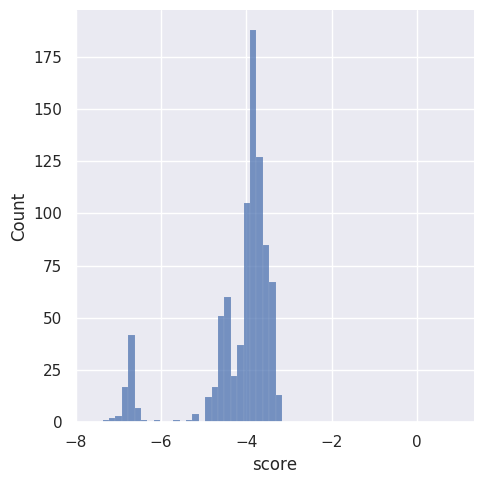

In [35]:
import seaborn as sns

sns.set(rc={"figure.dpi":100})

sns.displot(data = df, x="score")
plt.xlim(left=-8)
plt.show()

### Regression

In [ ]:
from functools import reduce
from sklearn.metrics import r2_score
from scipy.stats import spearmanr as spear

# print(hit_imp)

final_hit_imp = 1/np.mean(hit_imp, axis=1)

final_hit_nonimp = np.mean(hit_nonimp, axis=1)

IC50_mask = np.isfinite(IC50_list)
active_mask = [x < 5 for x in IC50_list ]
hit_mask = np.isfinite(final_hit_imp)
masks = IC50_mask + hit_mask
total_mask = reduce(np.logical_and, [IC50_mask, active_mask, hit_mask])
print(IC50_list)
print(mask)
print(np.array(IC50_list)[total_mask])
print(final_hit_imp[total_mask])
print(r2_score(final_hit_imp[total_mask], np.array(IC50_list)[total_mask]))
print(spear(final_hit_imp[total_mask], np.array(IC50_list)[total_mask])[0])

# # df1 = pd.DataFrame(list(zip(final_hit_imp, np.ones_like(final_hit_imp))), columns = ['score','hit'])
# df1 = pd.DataFrame(list(zip(final_hit_imp, list(map(int, activity_list)))), columns = ['score','hit'])
# # df1 = df1[df1['hit']==1]
# imp_df = df1
# imp_df.reset_index(inplace=True, drop=True)
# imp_df['hit'] = imp_df['hit'].astype('Int64').astype(bool)

# # df1 = pd.DataFrame(list(zip(final_hit_nonimp, np.ones_like(final_hit_nonimp))), columns = ['score','hit'])
# df1 = pd.DataFrame(list(zip(final_hit_nonimp, list(map(int, activity_list)))), columns = ['score','hit'])
# # df1 = df1[df1['hit']==1]
# nonimp_df = df1
# nonimp_df.reset_index(inplace=True, drop=True)
# nonimp_df['hit'] = nonimp_df['hit'].astype('Int64').astype(bool)

# pair_df = imp_df.join(nonimp_df, lsuffix='_imp', rsuffix='_nonimp')
# pair_df['score'] = pair_df['score_imp'] + pair_df['score_nonimp']

# # n_list = np.logspace(start=1, stop=np.log10(len(df2)), num=50)
# n_list = np.logspace(start=0, stop=2, num=20) # only check top 1000
# EF = [enrichment(pair_df, n=int(n), index='hit_imp') for n in n_list]
# EF_imp = [enrichment(imp_df, n=int(n), index='hit', log=True) for n in n_list]
# # EF_imp = [enrichment(imp_df, n=int(n), index='hit') for n in n_list]
# EF_nonimp = [enrichment(nonimp_df, n=int(n), index='hit') for n in n_list]

# orig_prop = len(imp_df[imp_df['hit']])/len(imp_df)

# fig = plt.figure(dpi=300)
# plt.plot(n_list, EF, 'k-', label='All')
# plt.plot(n_list, EF_imp, 'b-', label='Important')
# plt.plot(n_list, EF_nonimp, 'r-', label='Unimportant')
# # plt.title(r'Pair histogram $EF(n)$ - weighted by num points')
# # plt.title(r'Pair histogram $EF(n)$ - Unweighed')
# plt.title(r'2-body $EF(n)$ - Unweighed, X-ray confs, moonshot')
# # plt.xscale('log')
# plt.legend()
# plt.plot(n_list, np.ones_like(n_list), 'k:')
# extraticks = [1]
# plt.yticks(list(plt.yticks()[0]) + extraticks)
# plt.ylim(bottom=-1)
# # plt.title(r'Pair histogram $EF(n)$ - shannon entropy * num points')
# plt.xlabel('n')
# plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
# plt.show()

In [ ]:
important = ['Donor-Aromatic',
            'Aromatic-Acceptor',
            'Aromatic-Aromatic']

scores_active = []
scores_inactive = []

for i, pcore in enumerate(important):
    if i!=1:

        final_hit_imp = hit_imp[:,i]
        df = pd.DataFrame(list(zip(final_hit_imp, list(map(int, activity_list)))), columns = ['score','hit'])
        scores_active.append(df[df['hit']==1]['score'])
        scores_inactive.append(df[df['hit']==0]['score'])
        
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(scores_inactive[0], scores_inactive[1], c='r', label='inactive')
ax.scatter(scores_active[0], scores_active[1], c='b', label='active')

ax.set_xlabel(important[0])
ax.set_ylabel(important[2])

ax.legend()
plt.show()



In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
important = ['Donor-Aromatic',
            'Aromatic-Acceptor',
            'Aromatic-Aromatic']

scores_active = []
scores_inactive = []

for i, pcore in enumerate(important):

        final_hit_imp = hit_imp[:,i]
        df = pd.DataFrame(list(zip(final_hit_imp, list(map(int, activity_list)))), columns = ['score','hit'])
        scores_active.append(df[df['hit']==1]['score'])
        scores_inactive.append(df[df['hit']==0]['score'])
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(scores_inactive[0], scores_inactive[1], scores_inactive[2], c='r', label='inactive')
ax.scatter(scores_active[0], scores_active[1], scores_active[2], c='b', label='active')

ax.set_xlabel(important[0])
ax.set_ylabel(important[1])
ax.set_zlabel(important[2])



orig proportion of hit: 11.000%
N = 5, n_hits = 3, new proportion of hit: 60.000%
orig proportion of hit: 11.000%
N = 5, n_hits = 3, new proportion of hit: 60.000%
orig proportion of hit: 11.000%
N = 6, n_hits = 3, new proportion of hit: 50.000%
orig proportion of hit: 11.000%
N = 8, n_hits = 4, new proportion of hit: 50.000%
orig proportion of hit: 11.000%
N = 9, n_hits = 5, new proportion of hit: 55.556%
orig proportion of hit: 11.000%
N = 10, n_hits = 6, new proportion of hit: 60.000%
orig proportion of hit: 11.000%
N = 12, n_hits = 7, new proportion of hit: 58.333%
orig proportion of hit: 11.000%
N = 15, n_hits = 7, new proportion of hit: 46.667%
orig proportion of hit: 11.000%
N = 17, n_hits = 7, new proportion of hit: 41.176%
orig proportion of hit: 11.000%
N = 20, n_hits = 7, new proportion of hit: 35.000%
orig proportion of hit: 11.000%
N = 24, n_hits = 9, new proportion of hit: 37.500%
orig proportion of hit: 11.000%
N = 28, n_hits = 10, new proportion of hit: 35.714%
orig pro

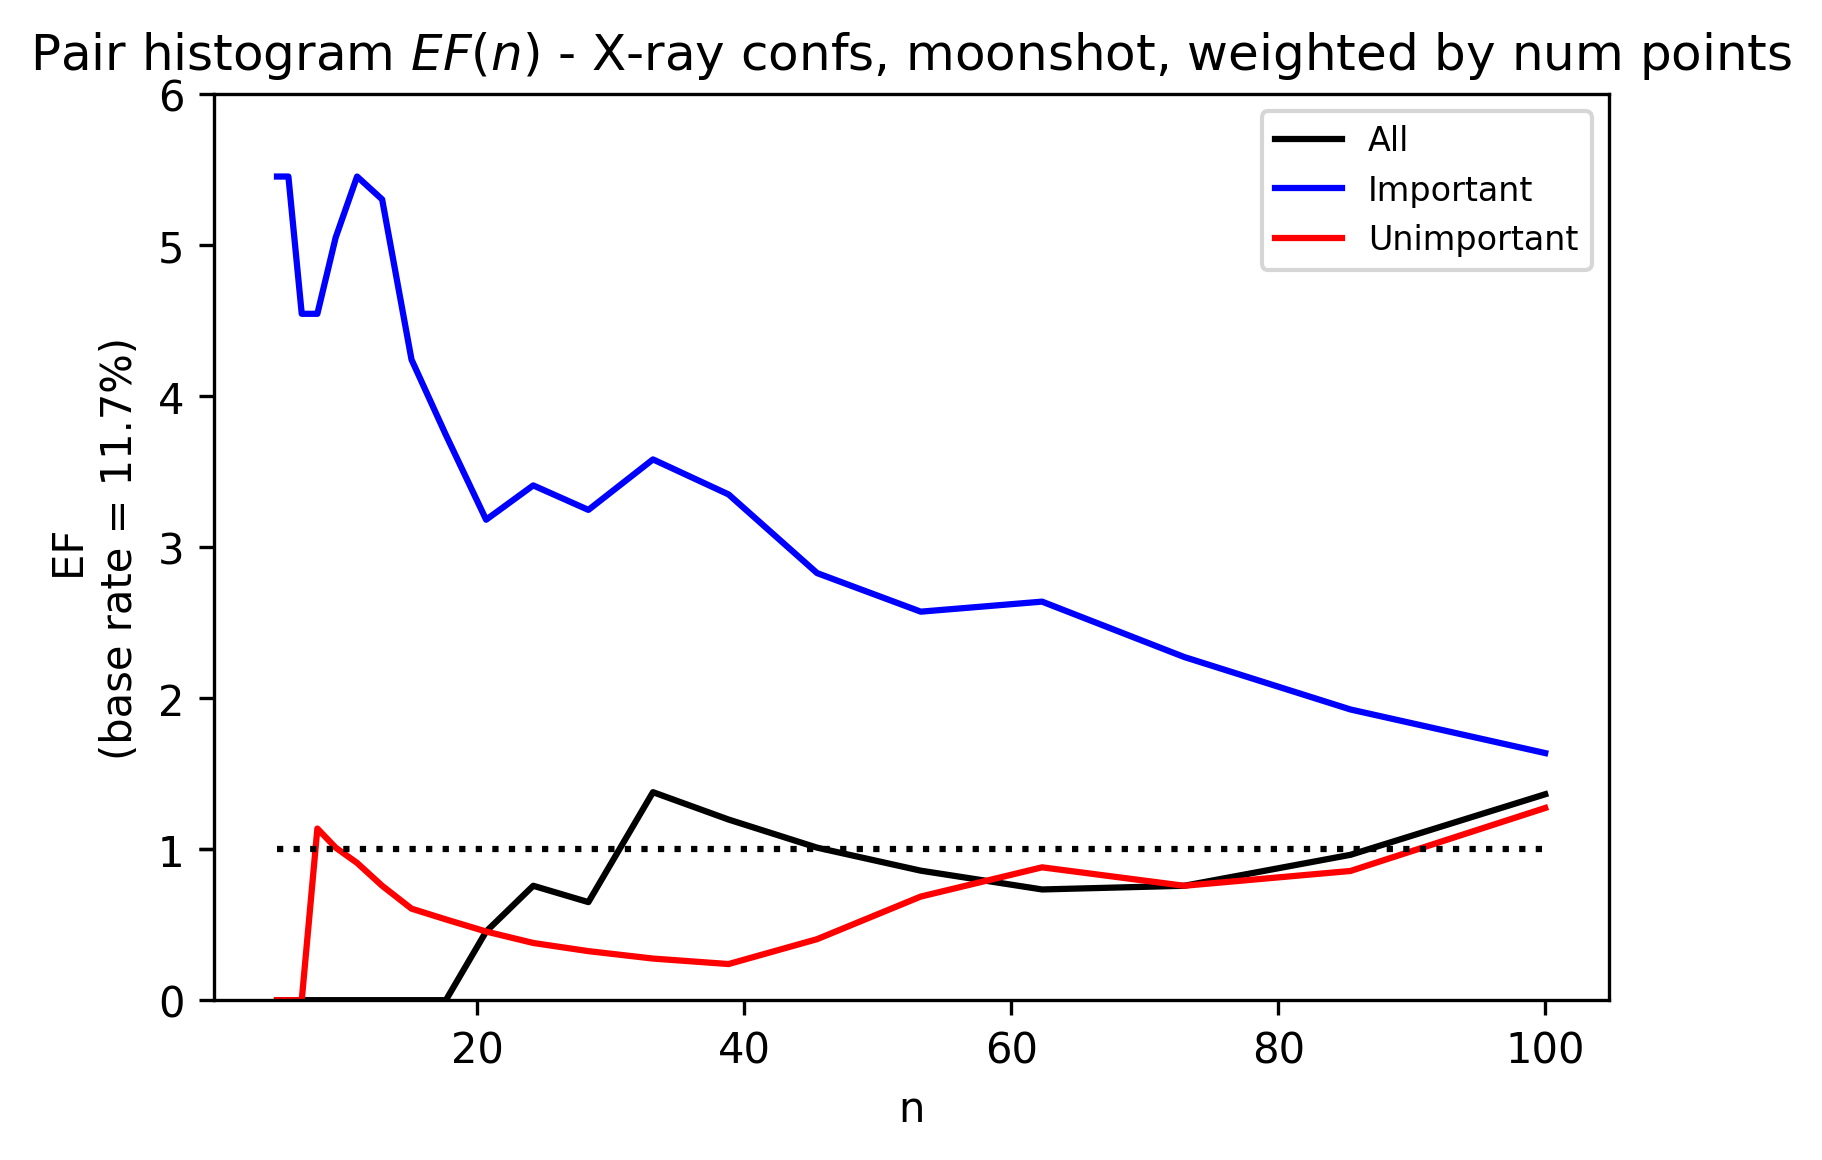

In [152]:


final_hit_imp = np.mean(hit_imp, axis=1)

final_hit_nonimp = np.mean(hit_nonimp, axis=1)

# df1 = pd.DataFrame(list(zip(final_hit_imp, np.ones_like(final_hit_imp))), columns = ['score','hit'])
df1 = pd.DataFrame(list(zip(final_hit_imp, list(map(int, activity_list)))), columns = ['score','hit'])
# df1 = df1[df1['hit']==1]
imp_df = df1
imp_df.reset_index(inplace=True, drop=True)
imp_df['hit'] = imp_df['hit'].astype('Int64').astype(bool)

# df1 = pd.DataFrame(list(zip(final_hit_nonimp, np.ones_like(final_hit_nonimp))), columns = ['score','hit'])
df1 = pd.DataFrame(list(zip(final_hit_nonimp, list(map(int, activity_list)))), columns = ['score','hit'])
# df1 = df1[df1['hit']==1]
nonimp_df = df1
nonimp_df.reset_index(inplace=True, drop=True)
nonimp_df['hit'] = nonimp_df['hit'].astype('Int64').astype(bool)

pair_df = imp_df.join(nonimp_df, lsuffix='_imp', rsuffix='_nonimp')
pair_df['score'] = pair_df['score_imp'] + pair_df['score_nonimp']

# n_list = np.logspace(start=1, stop=np.log10(len(df2)), num=50)
n_list = np.logspace(start=np.log10(5), stop=2, num=20) # only check top 1000
EF = [enrichment(pair_df, n=int(n), index='hit_imp') for n in n_list]
EF_imp = [enrichment(imp_df, n=int(n), index='hit', log=True) for n in n_list]
# EF_imp = [enrichment(imp_df, n=int(n), index='hit') for n in n_list]
EF_nonimp = [enrichment(nonimp_df, n=int(n), index='hit') for n in n_list]

orig_prop = len(imp_df[imp_df['hit']])/len(imp_df)

fig = plt.figure(dpi=300)
plt.plot(n_list, EF, 'k-', label='All')
plt.plot(n_list, EF_imp, 'b-', label='Important')
plt.plot(n_list, EF_nonimp, 'r-', label='Unimportant')
plt.title(r'Pair histogram $EF(n)$ - X-ray confs, moonshot, weighted by num points')
# plt.title(r'Pair histogram $EF(n)$ - Unweighed')
# plt.title(r'2-body $EF(n)$ - Unweighed, X-ray confs, moonshot')
# plt.xscale('log')
plt.legend(prop={'size': 8})
plt.plot(n_list, np.ones_like(n_list), 'k:')
extraticks = [1]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.ylim(bottom=0)
# plt.title(r'Pair histogram $EF(n)$ - shannon entropy * num points')
plt.xlabel('n')
plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
plt.show()

Text(0, 0.5, 'EF \n(base rate = 11.7%)')

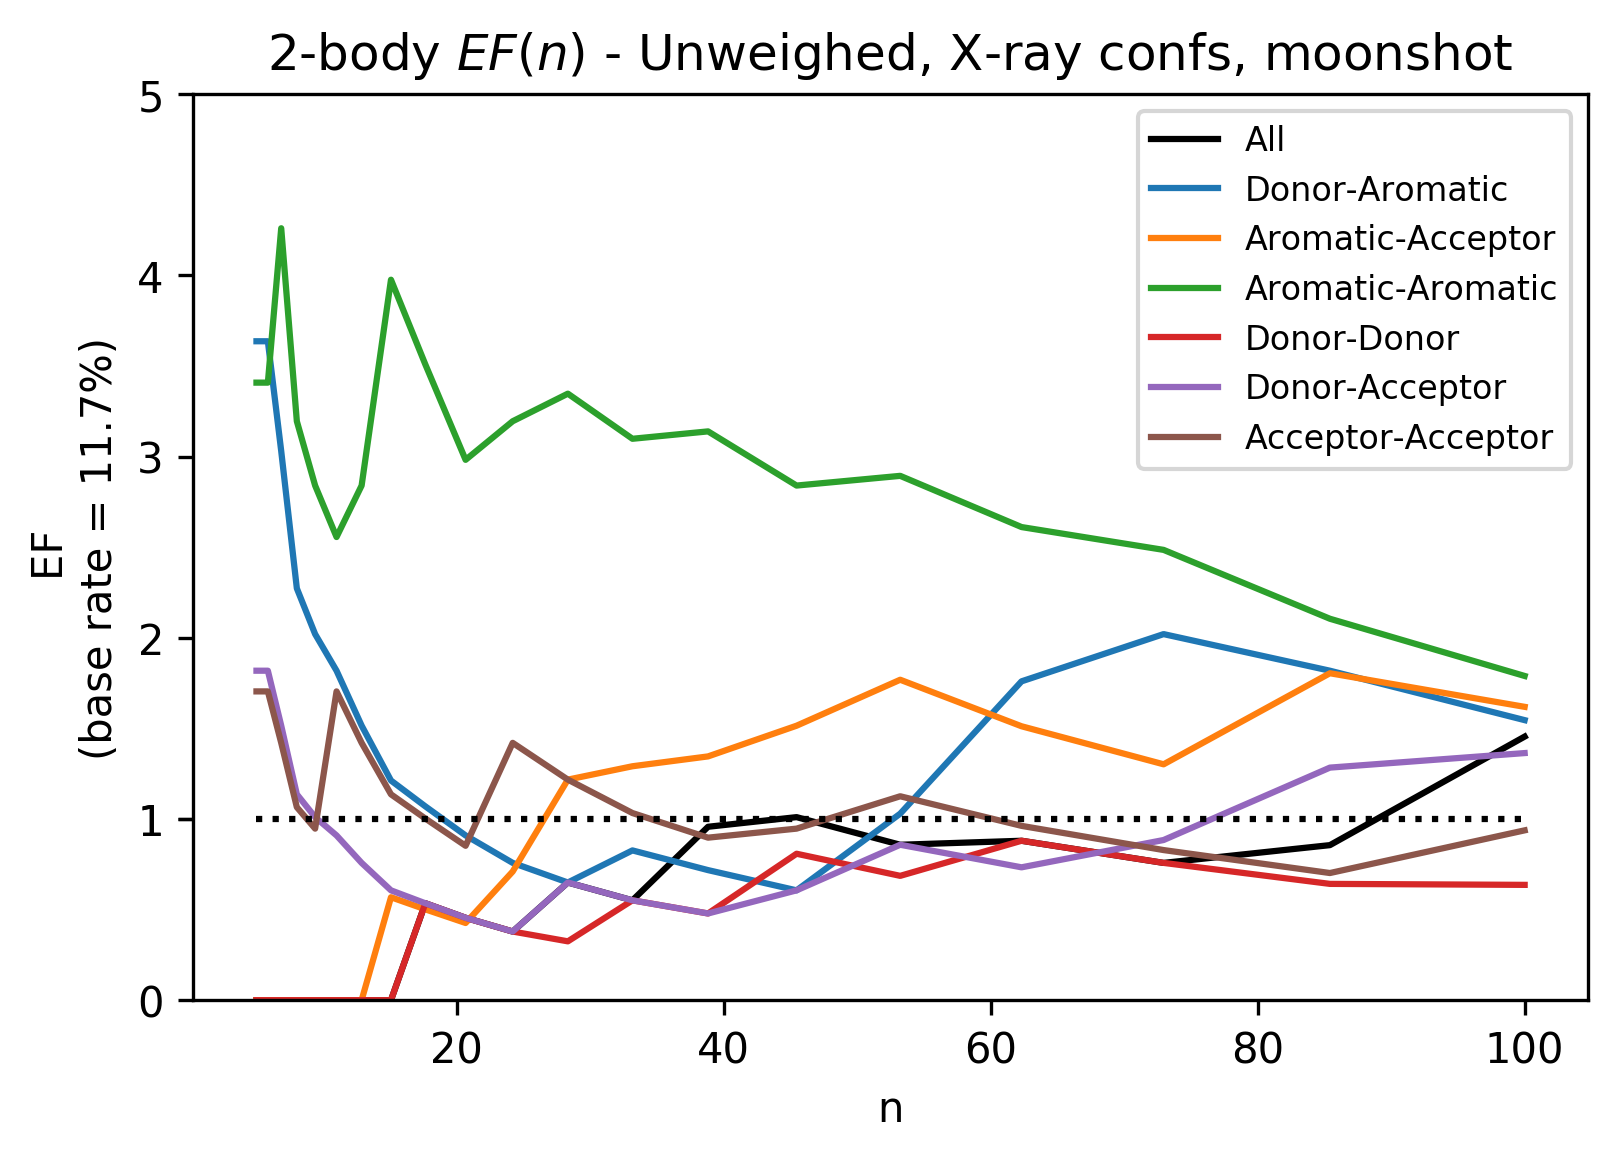

In [99]:
fig = plt.figure(dpi=300)
plt.plot(n_list, EF, 'k-', label='All')

for i, pcore in enumerate(important):

    final_hit_imp = hit_imp[:,i]
    df1 = pd.DataFrame(list(zip(final_hit_imp, list(map(int, activity_list)))), columns = ['score','hit'])
    imp_df = df1
    imp_df.reset_index(inplace=True, drop=True)
    imp_df['hit'] = imp_df['hit'].astype('Int64').astype(bool)
    
    EF_imp = [enrichment(imp_df, n=int(n), index='hit') for n in n_list]
    plt.plot(n_list, EF_imp, label=pcore)

for i, pcore in enumerate(unimportant):

    final_hit_nonimp = hit_nonimp[:,i]
    df1 = pd.DataFrame(list(zip(final_hit_nonimp, list(map(int, activity_list)))), columns = ['score','hit'])
    nonimp_df = df1
    nonimp_df.reset_index(inplace=True, drop=True)
    nonimp_df['hit'] = nonimp_df['hit'].astype('Int64').astype(bool)

    EF_nonimp = [enrichment(nonimp_df, n=int(n), index='hit') for n in n_list]
    plt.plot(n_list, EF_nonimp, label=pcore)

plt.title(r'2-body $EF(n)$ - Unweighed, X-ray confs, moonshot')
plt.legend(prop={'size': 8})
plt.plot(n_list, np.ones_like(n_list), 'k:')

extraticks = [1]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.ylim(bottom=0)
plt.xlabel('n')
plt.ylabel('EF')
orig_prop = len(imp_df[imp_df['hit']])/len(imp_df)
plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))

In [ ]:


# final_hit_imp = np.mean(hit_imp, axis=1)

# final_hit_nonimp = np.mean(hit_nonimp, axis=1)

# print(hit_nonimp)

# # df1 = pd.DataFrame(list(zip(final_hit_imp, np.ones_like(final_hit_imp))), columns = ['score','hit'])
# df1 = pd.DataFrame(list(zip(final_hit_imp, list(map(int, activity_list)))), columns = ['score','hit'])
# # df1 = df1[df1['hit']==1]
# imp_df = df1
# imp_df.reset_index(inplace=True, drop=True)
# imp_df['hit'] = imp_df['hit'].astype('Int64').astype(bool)

# # df1 = pd.DataFrame(list(zip(final_hit_nonimp, np.ones_like(final_hit_nonimp))), columns = ['score','hit'])
# df1 = pd.DataFrame(list(zip(final_hit_nonimp, list(map(int, activity_list)))), columns = ['score','hit'])
# # df1 = df1[df1['hit']==1]
# nonimp_df = df1
# nonimp_df.reset_index(inplace=True, drop=True)
# nonimp_df['hit'] = nonimp_df['hit'].astype('Int64').astype(bool)

# pair_df = imp_df.join(nonimp_df, lsuffix='_imp', rsuffix='_nonimp')
# pair_df['score'] = pair_df['score_imp'] + pair_df['score_nonimp']
# print(pair_df)
# # n_list = np.logspace(start=1, stop=np.log10(len(df2)), num=50)
# n_list = np.logspace(start=0, stop=2, num=20) # only check top 1000
# EF = [enrichment(pair_df, n=int(n), index='hit_imp', ascending=False) for n in n_list]
# EF_imp = [enrichment(imp_df, n=int(n), index='hit', log=True, ascending=False) for n in n_list]
# # EF_imp = [enrichment(imp_df, n=int(n), index='hit') for n in n_list]
# EF_nonimp = [enrichment(nonimp_df, n=int(n), index='hit', ascending=False) for n in n_list]

# orig_prop = len(imp_df[imp_df['hit']])/len(imp_df)

# fig = plt.figure(dpi=300)
# plt.plot(n_list, EF, 'k-', label='All')
# plt.plot(n_list, EF_imp, 'b-', label='Important')
# plt.plot(n_list, EF_nonimp, 'r-', label='Unimportant')
# # plt.title(r'Pair histogram $EF(n)$ - weighted by num points')
# # plt.title(r'Pair histogram $EF(n)$ - Unweighed')
# plt.title(r'2-body $EF(n)$ - Unweighed, fresh confs, moonshot, diff_score')
# # plt.xscale('log')
# plt.legend()
# plt.plot(n_list, np.ones_like(n_list), 'k:')
# extraticks = [1]
# plt.yticks(list(plt.yticks()[0]) + extraticks)
# plt.ylim(bottom=-1)
# # plt.title(r'Pair histogram $EF(n)$ - shannon entropy * num points')
# plt.xlabel('n')
# plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
# plt.show()

orig proportion of hit: 18.605%
N = 5, n_hits = 2, new proportion of hit: 40.000%
orig proportion of hit: 18.605%
N = 5, n_hits = 2, new proportion of hit: 40.000%
orig proportion of hit: 18.605%
N = 6, n_hits = 3, new proportion of hit: 50.000%
orig proportion of hit: 18.605%
N = 8, n_hits = 4, new proportion of hit: 50.000%
orig proportion of hit: 18.605%
N = 9, n_hits = 5, new proportion of hit: 55.556%
orig proportion of hit: 18.605%
N = 10, n_hits = 6, new proportion of hit: 60.000%
orig proportion of hit: 18.605%
N = 12, n_hits = 6, new proportion of hit: 50.000%
orig proportion of hit: 18.605%
N = 15, n_hits = 7, new proportion of hit: 46.667%
orig proportion of hit: 18.605%
N = 17, n_hits = 8, new proportion of hit: 47.059%
orig proportion of hit: 18.605%
N = 20, n_hits = 9, new proportion of hit: 45.000%
orig proportion of hit: 18.605%
N = 24, n_hits = 10, new proportion of hit: 41.667%
orig proportion of hit: 18.605%
N = 28, n_hits = 13, new proportion of hit: 46.429%
orig pr

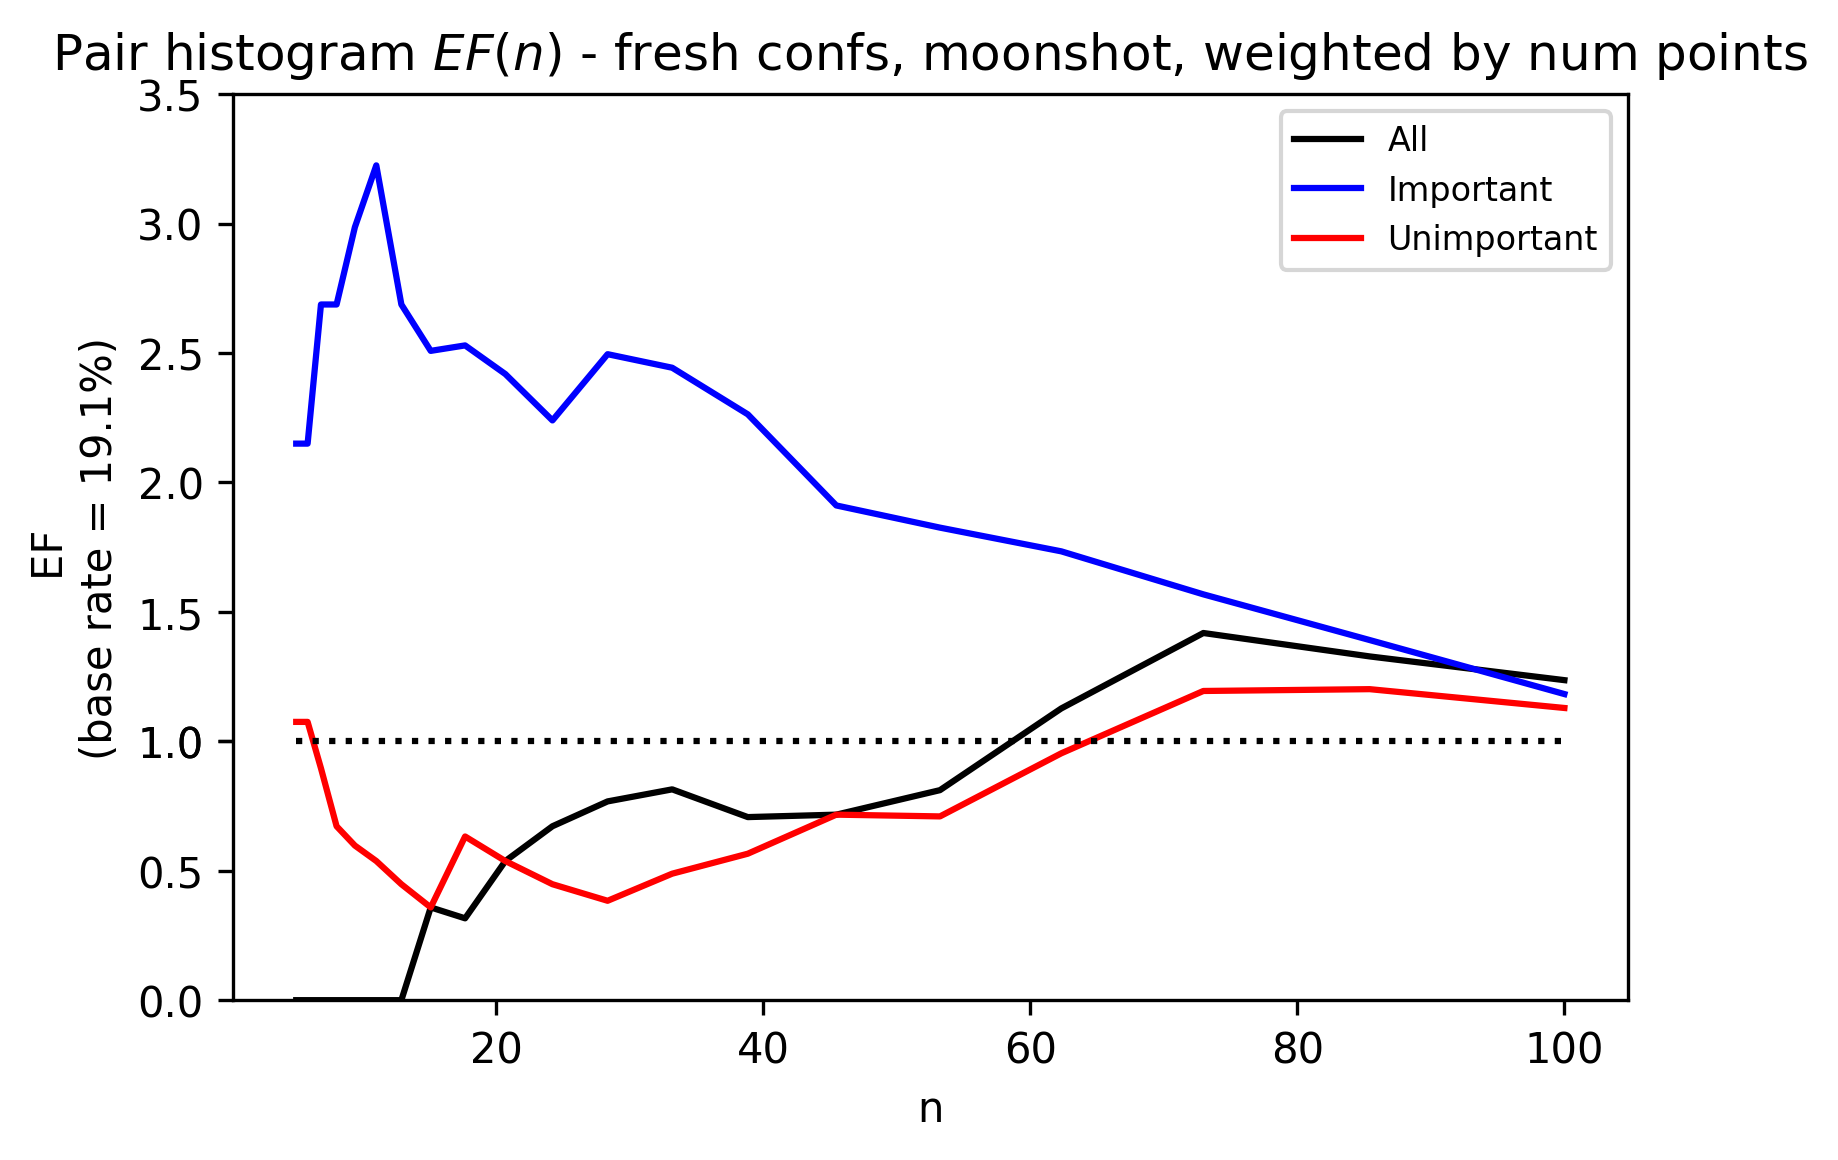

In [17]:
final_hit_imp = np.mean(hit_imp, axis=1)

final_hit_nonimp = np.mean(hit_nonimp, axis=1)

# df1 = pd.DataFrame(list(zip(final_hit_imp, np.ones_like(final_hit_imp))), columns = ['score','hit'])
df1 = pd.DataFrame(list(zip(final_hit_imp, list(map(int, activity_list)))), columns = ['score','hit'])
# df1 = df1[df1['hit']==1]
imp_df = df1
imp_df.reset_index(inplace=True, drop=True)
imp_df['hit'] = imp_df['hit'].astype('Int64').astype(bool)

# df1 = pd.DataFrame(list(zip(final_hit_nonimp, np.ones_like(final_hit_nonimp))), columns = ['score','hit'])
df1 = pd.DataFrame(list(zip(final_hit_nonimp, list(map(int, activity_list)))), columns = ['score','hit'])
# df1 = df1[df1['hit']==1]
nonimp_df = df1
nonimp_df.reset_index(inplace=True, drop=True)
nonimp_df['hit'] = nonimp_df['hit'].astype('Int64').astype(bool)

pair_df = imp_df.join(nonimp_df, lsuffix='_imp', rsuffix='_nonimp')
pair_df['score'] = pair_df['score_imp'] + pair_df['score_nonimp']
# print(pair_df.head())
# n_list = np.logspace(start=1, stop=np.log10(len(df2)), num=50)
n_list = np.logspace(start=np.log10(5), stop=2, num=20) # only check top 1000
EF = [enrichment(pair_df, n=int(n), index='hit_imp') for n in n_list]
EF_imp = [enrichment(imp_df, n=int(n), index='hit', log=True) for n in n_list]
# EF_imp = [enrichment(imp_df, n=int(n), index='hit') for n in n_list]
EF_nonimp = [enrichment(nonimp_df, n=int(n), index='hit') for n in n_list]


fig = plt.figure(dpi=300)
plt.plot(n_list, EF, 'k-', label='All')
plt.plot(n_list, EF_imp, 'b-', label='Important')
plt.plot(n_list, EF_nonimp, 'r-', label='Unimportant')
plt.title(r'Pair histogram $EF(n)$ - fresh confs, moonshot, weighted by num points')
# plt.title(r'Pair histogram $EF(n)$ - Unweighed')
# plt.title(r'2-body $EF(n)$ - Unweighed, fresh confs, moonshot')
# plt.xscale('log')
plt.legend(prop={'size': 8})
plt.plot(n_list, np.ones_like(n_list), 'k:')
extraticks = [1]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.ylim(bottom=0)
# plt.title(r'Pair histogram $EF(n)$ - shannon entropy * num points')
plt.xlabel('n')
orig_prop = len(imp_df[imp_df['hit']])/len(imp_df)
plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
plt.show()

Text(0, 0.5, 'EF \n(base rate = 11.7%)')

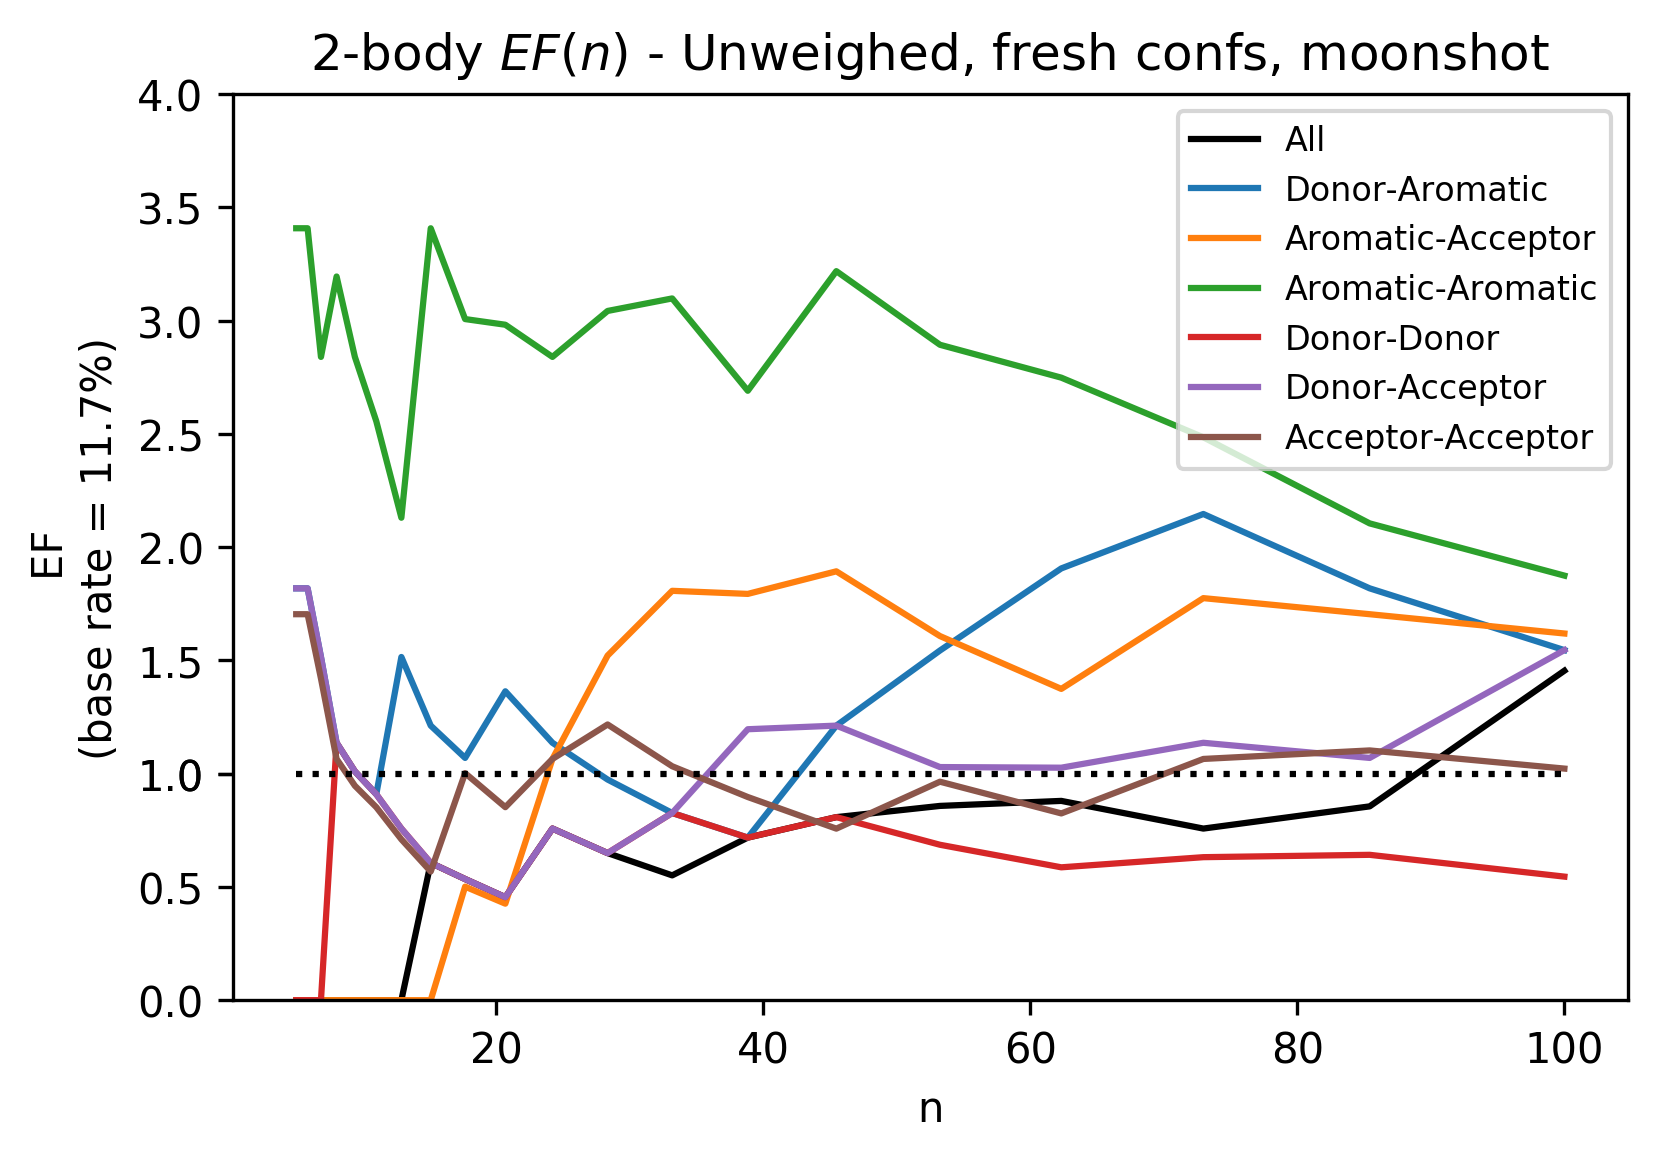

In [87]:
fig = plt.figure(dpi=300)
plt.plot(n_list, EF, 'k-', label='All')

for i, pcore in enumerate(important):

    final_hit_imp = hit_imp[:,i]
    df1 = pd.DataFrame(list(zip(final_hit_imp, list(map(int, activity_list)))), columns = ['score','hit'])
    imp_df = df1
    imp_df.reset_index(inplace=True, drop=True)
    imp_df['hit'] = imp_df['hit'].astype('Int64').astype(bool)
    
    EF_imp = [enrichment(imp_df, n=int(n), index='hit') for n in n_list]
    plt.plot(n_list, EF_imp, label=pcore)

for i, pcore in enumerate(unimportant):

    final_hit_nonimp = hit_nonimp[:,i]
    df1 = pd.DataFrame(list(zip(final_hit_nonimp, list(map(int, activity_list)))), columns = ['score','hit'])
    nonimp_df = df1
    nonimp_df.reset_index(inplace=True, drop=True)
    nonimp_df['hit'] = nonimp_df['hit'].astype('Int64').astype(bool)

    EF_nonimp = [enrichment(nonimp_df, n=int(n), index='hit') for n in n_list]
    plt.plot(n_list, EF_nonimp, label=pcore)

plt.title(r'2-body $EF(n)$ - Unweighed, fresh confs, moonshot')
plt.legend(prop={'size': 8})
plt.plot(n_list, np.ones_like(n_list), 'k:')

extraticks = [1]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.ylim(bottom=0)
plt.xlabel('n')
orig_prop = len(imp_df[imp_df['hit']])/len(imp_df)
plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))




In [ ]:
final_hit_imp = np.prod(hit_imp, axis=1)


final_zinc_imp = np.prod(zinc_imp, axis=1)

final_hit_nonimp = np.prod(hit_nonimp, axis=1)
final_zinc_nonimp = np.prod(zinc_nonimp, axis=1)

# df1 = pd.DataFrame(list(zip(final_hit_imp, np.ones_like(final_hit_imp))), columns = ['score','hit'])
df1 = pd.DataFrame(list(zip(final_hit_imp, list(map(int, activity_list)))), columns = ['score','hit'])
df1 = df1[df1['hit']==1]
df2 = pd.DataFrame(list(zip(final_zinc_imp, np.zeros_like(final_zinc_imp))), columns = ['score','hit'])
imp_df = pd.concat([df1, df2])
imp_df.reset_index(inplace=True, drop=True)
imp_df['hit'] = imp_df['hit'].astype('Int64').astype(bool)

# df1 = pd.DataFrame(list(zip(final_hit_nonimp, np.ones_like(final_hit_nonimp))), columns = ['score','hit'])
df1 = pd.DataFrame(list(zip(final_hit_nonimp, list(map(int, activity_list)))), columns = ['score','hit'])
df1 = df1[df1['hit']==1]
df2 = pd.DataFrame(list(zip(final_zinc_nonimp, np.zeros_like(final_zinc_nonimp))), columns = ['score','hit'])
nonimp_df = pd.concat([df1, df2])
nonimp_df.reset_index(inplace=True, drop=True)
nonimp_df['hit'] = nonimp_df['hit'].astype('Int64').astype(bool)

pair_df = imp_df.join(nonimp_df, lsuffix='_imp', rsuffix='_nonimp')
pair_df['score'] = pair_df['score_imp'] + pair_df['score_nonimp']

# n_list = np.logspace(start=1, stop=np.log10(len(df2)), num=50)
n_list = np.logspace(start=1, stop=np.log10(1000), num=20) # only check top 1000
EF = [enrichment(pair_df, n=int(n), index='hit_imp', ascending=False) for n in n_list]
# EF_imp = [enrichment(imp_df, n=int(n), index='hit', log=True) for n in n_list]
EF_imp = [enrichment(imp_df, n=int(n), index='hit', ascending=False) for n in n_list]
EF_nonimp = [enrichment(nonimp_df, n=int(n), index='hit', ascending=False) for n in n_list]


fig = plt.figure(dpi=300)
plt.plot(n_list, EF, 'k-', label='All')
plt.plot(n_list, EF_imp, 'b-', label='Important')
plt.plot(n_list, EF_nonimp, 'r-', label='Unimportant')
# plt.title(r'Pair histogram $EF(n)$ - weighted by num points')
# plt.title(r'Pair histogram $EF(n)$ - Unweighed')
plt.title(r'Pair histogram $EF(n)$ - Unweighed, fresh confs, raw_score')
# plt.xscale('log')
plt.legend(prop={'size': 8})
# plt.title(r'Pair histogram $EF(n)$ - shannon entropy * num points')
plt.xlabel('n')
plt.ylabel('EF')
plt.plot(n_list, np.ones_like(n_list), 'k:')

extraticks = [1]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.ylim(bottom=0)
plt.show()

         score    hit
0     0.006277   True
1     0.006288   True
2     0.006387   True
3     0.006233   True
4     0.006335   True
...        ...    ...
2021  0.006227  False
2022  0.008336  False
2023  0.007914  False
2024  0.007073  False
2025  0.013150  False

[2026 rows x 2 columns]
orig proportion of hit: 1.418%
N = 10, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 1.418%
N = 11, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 1.418%
N = 12, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 1.418%
N = 14, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 1.418%
N = 16, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 1.418%
N = 18, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 1.418%
N = 20, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 1.418%
N = 23, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 1.418%
N = 26, n_hits = 0, new proporti

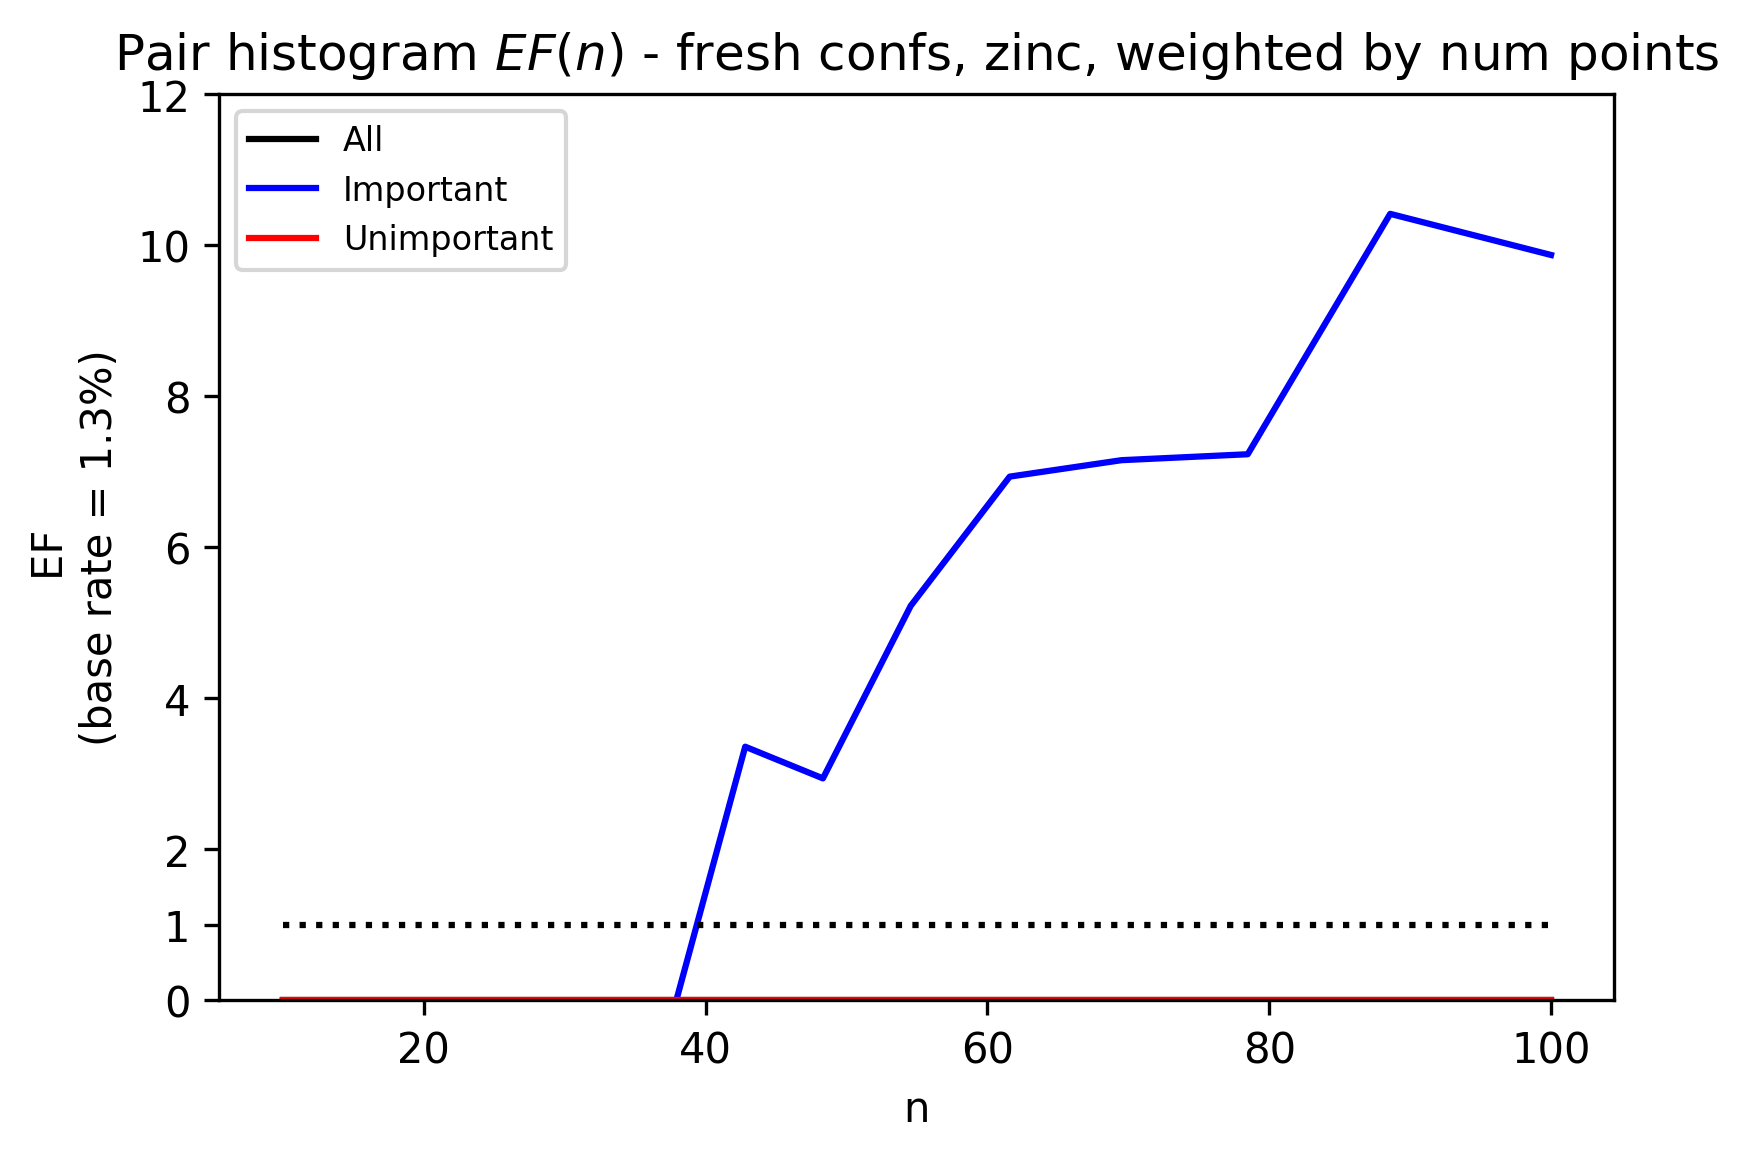

In [18]:
final_hit_imp = np.mean(hit_imp, axis=1)
final_zinc_imp = np.mean(zinc_imp, axis=1)

final_hit_nonimp = np.mean(hit_nonimp, axis=1)
final_zinc_nonimp = np.mean(zinc_nonimp, axis=1)

# df1 = pd.DataFrame(list(zip(final_hit_imp, np.ones_like(final_hit_imp))), columns = ['score','hit'])
df1 = pd.DataFrame(list(zip(final_hit_imp, list(map(int, activity_list)))), columns = ['score','hit'])
df1 = df1[df1['hit']==1]
df2 = pd.DataFrame(list(zip(final_zinc_imp, np.zeros_like(final_zinc_imp))), columns = ['score','hit'])
imp_df = pd.concat([df1, df2])
imp_df.reset_index(inplace=True, drop=True)
imp_df['hit'] = imp_df['hit'].astype('Int64').astype(bool)

# df1 = pd.DataFrame(list(zip(final_hit_nonimp, np.ones_like(final_hit_nonimp))), columns = ['score','hit'])
df1 = pd.DataFrame(list(zip(final_hit_nonimp, list(map(int, activity_list)))), columns = ['score','hit'])
df1 = df1[df1['hit']==1]
df2 = pd.DataFrame(list(zip(final_zinc_nonimp, np.zeros_like(final_zinc_nonimp))), columns = ['score','hit'])
nonimp_df = pd.concat([df1, df2])
nonimp_df.reset_index(inplace=True, drop=True)
nonimp_df['hit'] = nonimp_df['hit'].astype('Int64').astype(bool)

pair_df = imp_df.join(nonimp_df, lsuffix='_imp', rsuffix='_nonimp')
pair_df['score'] = pair_df['score_imp'] + pair_df['score_nonimp']
print(imp_df)
# n_list = np.logspace(start=1, stop=np.log10(len(df2)), num=50)

n_list = np.logspace(start=1, stop=np.log10(100), num=20) # only check top 1000
EF = [enrichment(pair_df, n=int(n), index='hit_imp') for n in n_list]
EF_imp = [enrichment(imp_df, n=int(n), index='hit', log=True) for n in n_list]
# EF_imp = [enrichment(imp_df, n=int(n), index='hit') for n in n_list]
EF_nonimp = [enrichment(nonimp_df, n=int(n), index='hit') for n in n_list]

fig = plt.figure(dpi=300)
plt.plot(n_list, EF, 'k-', label='All')
plt.plot(n_list, EF_imp, 'b-', label='Important')
plt.plot(n_list, EF_nonimp, 'r-', label='Unimportant')
plt.title(r'Pair histogram $EF(n)$ - fresh confs, zinc, weighted by num points')
# plt.title(r'Pair histogram $EF(n)$ - Unweighed')
# plt.title(r'2-body $EF(n)$ - Unweighed, fresh confs')
# plt.xscale('log')
plt.legend(prop={'size': 8})
# plt.title(r'Pair histogram $EF(n)$ - shannon entropy * num points')
plt.xlabel('n')
plt.ylabel('EF')
plt.plot(n_list, np.ones_like(n_list), 'k:')

extraticks = [1]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.ylim(bottom=0)
orig_prop = len(imp_df[imp_df['hit']])/len(imp_df)
plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
plt.show()

(0, 12.0)

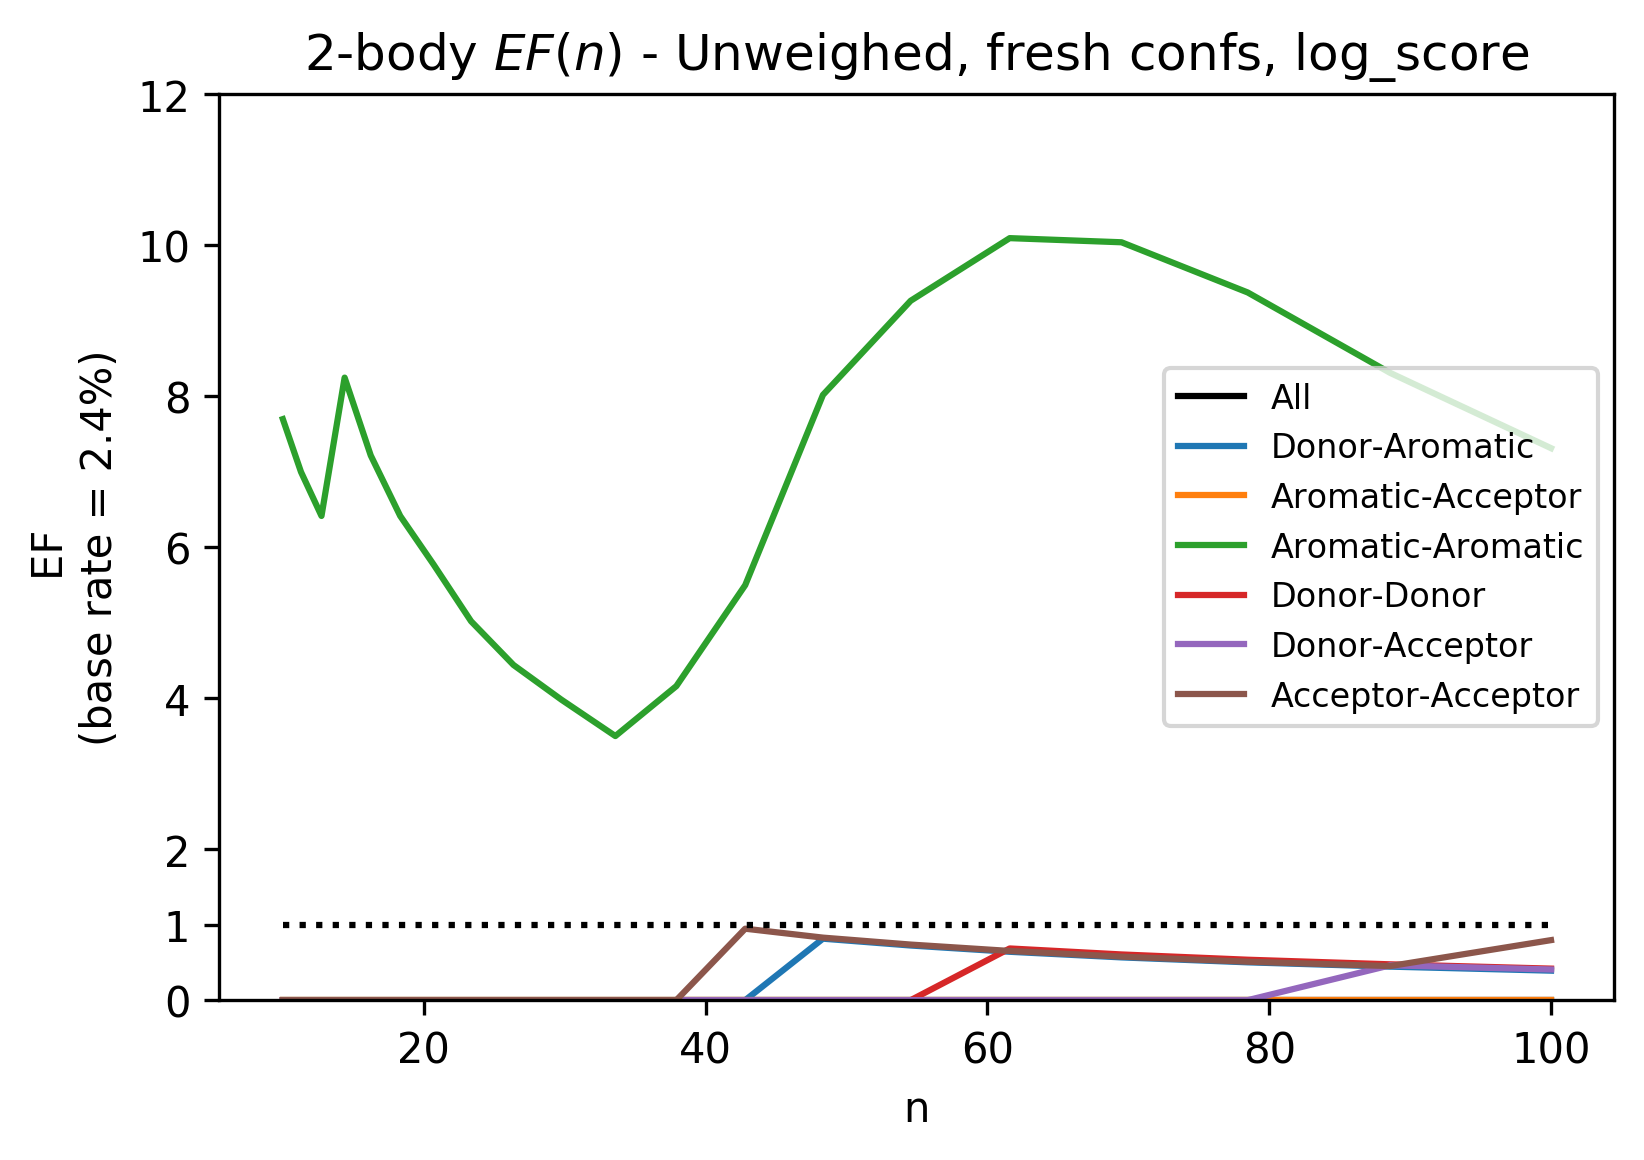

In [108]:
final_hit_imp = np.mean(hit_imp, axis=1)
final_zinc_imp = np.mean(zinc_imp, axis=1)

final_hit_nonimp = np.mean(hit_nonimp, axis=1)
final_zinc_nonimp = np.mean(zinc_nonimp, axis=1)

df1 = pd.DataFrame(list(zip(final_hit_imp, list(map(int, activity_list)))), columns = ['score','hit'])
df1 = df1[df1['hit']==1]
df2 = pd.DataFrame(list(zip(final_zinc_imp, np.zeros_like(final_zinc_imp))), columns = ['score','hit'])
imp_df = pd.concat([df1, df2])
imp_df.reset_index(inplace=True, drop=True)
imp_df['hit'] = imp_df['hit'].astype('Int64').astype(bool)

df1 = pd.DataFrame(list(zip(final_hit_nonimp, list(map(int, activity_list)))), columns = ['score','hit'])
df1 = df1[df1['hit']==1]
df2 = pd.DataFrame(list(zip(final_zinc_nonimp, np.zeros_like(final_zinc_nonimp))), columns = ['score','hit'])
nonimp_df = pd.concat([df1, df2])
nonimp_df.reset_index(inplace=True, drop=True)
nonimp_df['hit'] = nonimp_df['hit'].astype('Int64').astype(bool)

pair_df = imp_df.join(nonimp_df, lsuffix='_imp', rsuffix='_nonimp')
pair_df['score'] = pair_df['score_imp'] + pair_df['score_nonimp']

n_list = np.logspace(start=1, stop=np.log10(100), num=20) # only check top 1000
EF = [enrichment(pair_df, n=int(n), index='hit_imp') for n in n_list]

fig = plt.figure(dpi=300)
plt.plot(n_list, EF, 'k-', label='All')

for i, pcore in enumerate(important):

    final_hit_imp = hit_imp[:,i]
    final_zinc_imp = zinc_imp[:,i]
    # df1 = pd.DataFrame(list(zip(final_hit_imp, np.ones_like(final_hit_imp))), columns = ['score','hit'])
    df1 = pd.DataFrame(list(zip(final_hit_imp, list(map(int, activity_list)))), columns = ['score','hit'])
    df1 = df1[df1['hit']==1]
    df2 = pd.DataFrame(list(zip(final_zinc_imp, np.zeros_like(final_zinc_imp))), columns = ['score','hit'])
    imp_df = pd.concat([df1, df2])
    imp_df.reset_index(inplace=True, drop=True)
    imp_df['hit'] = imp_df['hit'].astype('Int64').astype(bool)
    
    EF_imp = [enrichment(imp_df, n=int(n), index='hit') for n in n_list]
    plt.plot(n_list, EF_imp, label=pcore)
    
final_hit_nonimp = np.mean(hit_nonimp, axis=1)
final_zinc_nonimp = np.mean(zinc_nonimp, axis=1)

for i, pcore in enumerate(unimportant):

    final_hit_nonimp = hit_nonimp[:,i]
    final_zinc_nonimp = zinc_nonimp[:,i]
    # df1 = pd.DataFrame(list(zip(final_hit_imp, np.ones_like(final_hit_imp))), columns = ['score','hit'])
    df1 = pd.DataFrame(list(zip(final_hit_nonimp, list(map(int, activity_list)))), columns = ['score','hit'])
    df1 = df1[df1['hit']==1]
    df2 = pd.DataFrame(list(zip(final_zinc_nonimp, np.zeros_like(final_zinc_imp))), columns = ['score','hit'])
    nonimp_df = pd.concat([df1, df2])
    nonimp_df.reset_index(inplace=True, drop=True)
    nonimp_df['hit'] = nonimp_df['hit'].astype('Int64').astype(bool)

    EF_nonimp = [enrichment(nonimp_df, n=int(n), index='hit') for n in n_list]
    plt.plot(n_list, EF_nonimp, label=pcore)

# plt.title(r'Pair histogram $EF(n)$ - Unweighed')
plt.title(r'2-body $EF(n)$ - Unweighed, fresh confs, log_score')

# plt.xscale('log')
plt.legend(prop={'size': 8})
# plt.title(r'Pair histogram $EF(n)$ - shannon entropy * num points')
plt.xlabel('n')
orig_prop = len(imp_df[imp_df['hit']])/len(imp_df)
plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
plt.plot(n_list, np.ones_like(n_list), 'k:')

extraticks = [1]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.ylim(bottom=0)
# plt.savefig('pair_ef.pdf')

In [ ]:
# from IPython.display import display
# # pd.set_option('display.max_rows', 100)
# print(pair_df.sort_values(by='score').head(100))
# print(df1['score'].max())
# print(df1['score'].min())

In [ ]:
# hit_scores_trip = np.empty((len(hit_trips), 27))
# zinc_scores_trip = np.empty((len(zinc_trips), 27))

# n=0
# for pcore_trip in tqdm(product(interesting_pcores,repeat=3), total=27):
#     core_a,core_b,core_c = pcore_trip
#     combo = core_a+'-'+core_b+'-'+core_c

#     num_weight = frag_trip_distance_dict[combo].shape[1]

# #     kde = KernelDensity(kernel='gaussian', rtol=1e-4).fit(frag_trip_distance_dict[combo].T)
# #     ent_weight = entropy(np.exp(kde.score_samples(frag_trip_distance_dict[combo].T)))

# #     params = {'bandwidth': np.logspace(-1, 1, 5)}

# #     grid = GridSearchCV(KernelDensity(kernel='gaussian', rtol=1e-4), params)
# #     grid.fit(frag_trip_distance_dict[combo].T)
# #     print(pcore_trip)
# #     print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

#     # use the best estimator to compute the kernel density estimate
# #     kde = grid.best_estimator_

#     kde = kde_dict[combo]
#     for i in range(len(hit_trips)):   
#         try:
#             ith_score = np.abs(kde.score_samples(hit_trips[i][combo][0].T))/num_weight
# #             ith_score = np.abs(kde.score_samples(hit_inds2[i][combo][0].T))/ent_weight
#             hit_scores_trip[i,n] = np.mean(ith_score)
#         except:
#             hit_scores_trip[i,n] = np.nan

#     for j in range(len(zinc_trips)):
#         try:
#             jth_score = np.abs(kde.score_samples(zinc_trips[j][combo][0].T))/num_weight
# #             jth_score = np.abs(kde.score_samples(zinc_inds2[j][combo][0].T))/ent_weight
#             zinc_scores_trip[j,n] = np.mean(jth_score)
#         except:
#             zinc_scores_trip[j,n] = np.nan
#     n+=1
    
# final_hit_score = np.mean(hit_scores_trip, axis=1)
# final_zinc_score = np.mean(zinc_scores_trip, axis=1)

# hit_mask = np.isfinite(final_hit_score)
# zinc_mask = np.isfinite(final_zinc_score)

# df1 = pd.DataFrame(list(zip(final_hit_score, np.ones_like(final_hit_score))), columns = ['score','hit'])
# df2 = pd.DataFrame(list(zip(final_zinc_score, np.zeros_like(final_zinc_score))), columns = ['score','hit'])

# trip_df = pd.concat([df1, df2])
# trip_df['hit'] = trip_df['hit'].astype('Int64').astype(bool)

# print('Triplet histogram EF: {:.3f}'.format(enrichment(trip_df, n=100, index='hit', log=True)))

# n_list = np.logspace(start=1, stop=np.log10(len(df2)), num=50)
# EF = [enrichment(trip_df, n=int(n), index='hit') for n in n_list]

# fig = plt.figure()
# plt.plot(n_list, EF, 'b-')
# plt.title(r'Triplet histogram $EF(n)$')
# plt.xlabel('n')
# plt.ylabel('EF')
# plt.show()

In [ ]:
final_hit_imp = np.mean(hit_imp_trip, axis=1)
final_zinc_imp = np.mean(zinc_imp_trip, axis=1)

final_hit_nonimp = np.mean(hit_nonimp_trip, axis=1)
final_zinc_nonimp = np.mean(zinc_nonimp_trip, axis=1)

df1 = pd.DataFrame(list(zip(final_hit_imp, np.ones_like(final_hit_imp))), columns = ['score','hit'])
df2 = pd.DataFrame(list(zip(final_zinc_imp, np.zeros_like(final_zinc_imp))), columns = ['score','hit'])
imp_df = pd.concat([df1, df2])
imp_df.reset_index(inplace=True, drop=True)
imp_df['hit'] = imp_df['hit'].astype('Int64').astype(bool)

df1 = pd.DataFrame(list(zip(final_hit_nonimp, np.ones_like(final_hit_nonimp))), columns = ['score','hit'])
df2 = pd.DataFrame(list(zip(final_zinc_nonimp, np.zeros_like(final_zinc_nonimp))), columns = ['score','hit'])
nonimp_df = pd.concat([df1, df2])
nonimp_df.reset_index(inplace=True, drop=True)
nonimp_df['hit'] = nonimp_df['hit'].astype('Int64').astype(bool)

trip_df = imp_df.join(nonimp_df, lsuffix='_imp', rsuffix='_nonimp')
trip_df['score'] = trip_df['score_imp'] + trip_df['score_nonimp']

n_list = np.logspace(start=1, stop=np.log10(len(df2)), num=50)
EF = [enrichment(pair_df, n=int(n), index='hit_imp') for n in n_list]
EF_imp = [enrichment(imp_df, n=int(n), index='hit') for n in n_list]
EF_nonimp = [enrichment(nonimp_df, n=int(n), index='hit') for n in n_list]


fig = plt.figure(dpi=300)
plt.plot(n_list, EF, 'k-', label='All')
plt.plot(n_list, EF_imp, 'b-', label='Important')
plt.plot(n_list, EF_nonimp, 'r-', label='Unimportant')
plt.title(r'Triplet histogram $EF(n)$ - unweigh')
plt.legend()
plt.xlabel('n')
plt.ylabel('EF')
plt.show()



In [29]:
important = ['Donor-Donor-Donor',
            'Donor-Acceptor-Acceptor',
            'Acceptor-Acceptor-Acceptor',
            'Acceptor-Acceptor-Aromatic',
            'Acceptor-Aromatic-Aromatic',
            'Aromatic-Aromatic-Aromatic']

unimportant = ['Donor-Donor-Acceptor',
               'Donor-Donor-Aromatic',
               'Donor-Acceptor-Aromatic',
               'Donor-Aromatic-Aromatic']

trips = important + unimportant

hit_imp_trip = np.empty((len(hit_trips), len(important)))
# zinc_imp_trip = np.empty((len(zinc_trips), len(important)))

hit_nonimp_trip = np.empty((len(hit_trips), len(unimportant)))
# zinc_nonimp_trip = np.empty((len(zinc_trips), len(unimportant)))

m = 0
p = 0 
for combo in tqdm(trips):
    core_a,core_b,core_c = combo.split('-')

    #     kde = KernelDensity(kernel='gaussian', rtol=1e-4).fit(frag_trip_distance_dict[combo].T)
    #     ent_weight = entropy(np.exp(kde.score_samples(frag_trip_distance_dict[combo].T)))

    #     params = {'bandwidth': np.logspace(-1, 1, 5)}

    #     grid = GridSearchCV(KernelDensity(kernel='gaussian', rtol=1e-4), params)
    #     grid.fit(frag_trip_distance_dict[combo].T)
    #     print(pcore_trip)
    #     print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

        # use the best estimator to compute the kernel density estimate
    #     kde = grid.best_estimator_

    kde = kde_dict[combo]
    for i in range(len(hit_trips)):   
        try:
            ith_score = np.abs(kde.score_samples(hit_trips[i][combo][0].T))
            if combo in important:
                hit_imp_trip[i,m] = np.mean(ith_score)
            else:
                hit_nonimp_trip[i,p] = np.mean(ith_score)
        except:
            if combo in important:
                hit_imp_trip[i,m] = np.nan
            else:
                hit_nonimp_trip[i,p] = np.nan

#         for j in range(len(zinc_trips)):
#             try:
#                 jth_score = np.abs(kde.score_samples(zinc_trips[j][combo][0].T)
#                 if combo in important:
#                     zinc_imp_trip[j,m] = np.mean(jth_score)
#                 else:
#                     zinc_nonimp_trip[j,p] = np.mean(jth_score)
#             except:
#                 if combo in important:
#                     zinc_imp_trip[j,m] = np.nan
#                 else:
#                     zinc_nonimp_trip[j,p] = np.nan
    if combo in important:
        m+=1
    else:
        p+=1


100%|██████████| 10/10 [12:11<00:00, 73.18s/it]


orig proportion of hit: 11.000%
N = 1, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 11.000%
N = 1, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 11.000%
N = 1, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 11.000%
N = 2, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 11.000%
N = 2, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 11.000%
N = 3, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 11.000%
N = 4, n_hits = 1, new proportion of hit: 25.000%
orig proportion of hit: 11.000%
N = 5, n_hits = 1, new proportion of hit: 20.000%
orig proportion of hit: 11.000%
N = 6, n_hits = 1, new proportion of hit: 16.667%
orig proportion of hit: 11.000%
N = 8, n_hits = 1, new proportion of hit: 12.500%
orig proportion of hit: 11.000%
N = 11, n_hits = 1, new proportion of hit: 9.091%
orig proportion of hit: 11.000%
N = 14, n_hits = 1, new proportion of hit: 7.143%
orig proportion of hit

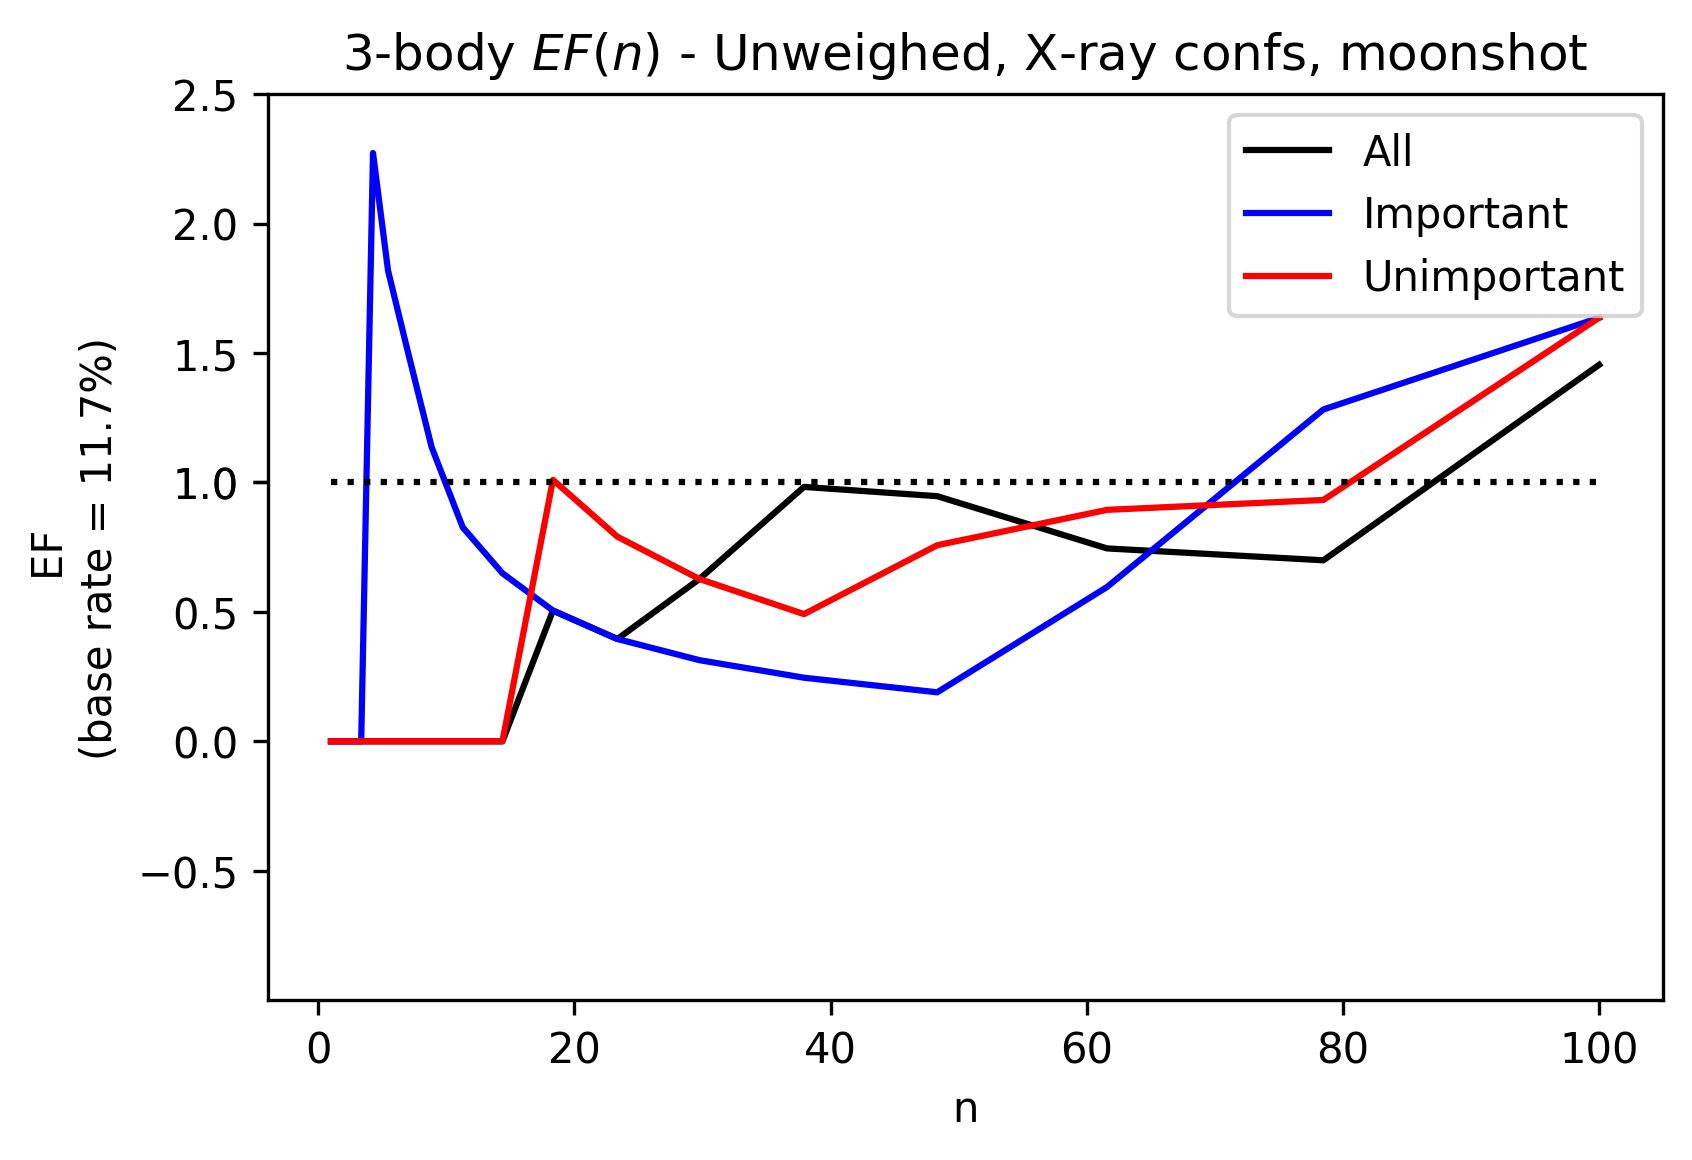

In [30]:
final_hit_imp = np.mean(hit_imp_trip, axis=1)

final_hit_nonimp = np.mean(hit_nonimp_trip, axis=1)

# df1 = pd.DataFrame(list(zip(final_hit_imp, np.ones_like(final_hit_imp))), columns = ['score','hit'])
df1 = pd.DataFrame(list(zip(final_hit_imp, list(map(int, activity_list)))), columns = ['score','hit'])
# df1 = df1[df1['hit']==1]
imp_df = df1
imp_df.reset_index(inplace=True, drop=True)
imp_df['hit'] = imp_df['hit'].astype('Int64').astype(bool)

# df1 = pd.DataFrame(list(zip(final_hit_nonimp, np.ones_like(final_hit_nonimp))), columns = ['score','hit'])
df1 = pd.DataFrame(list(zip(final_hit_nonimp, list(map(int, activity_list)))), columns = ['score','hit'])
# df1 = df1[df1['hit']==1]
nonimp_df = df1
nonimp_df.reset_index(inplace=True, drop=True)
nonimp_df['hit'] = nonimp_df['hit'].astype('Int64').astype(bool)

trip_df = imp_df.join(nonimp_df, lsuffix='_imp', rsuffix='_nonimp')
trip_df['score'] = trip_df['score_imp'] + trip_df['score_nonimp']

# n_list = np.logspace(start=1, stop=np.log10(len(df2)), num=50)
n_list = np.logspace(start=0, stop=2, num=20) # only check top 1000
EF = [enrichment(pair_df, n=int(n), index='hit_imp') for n in n_list]
EF_imp = [enrichment(imp_df, n=int(n), index='hit', log=True) for n in n_list]
# EF_imp = [enrichment(imp_df, n=int(n), index='hit') for n in n_list]
EF_nonimp = [enrichment(nonimp_df, n=int(n), index='hit') for n in n_list]

orig_prop = len(imp_df[imp_df['hit']])/len(imp_df)

fig = plt.figure(dpi=300)
plt.plot(n_list, EF, 'k-', label='All')
plt.plot(n_list, EF_imp, 'b-', label='Important')
plt.plot(n_list, EF_nonimp, 'r-', label='Unimportant')
# plt.title(r'Pair histogram $EF(n)$ - weighted by num points')
# plt.title(r'Pair histogram $EF(n)$ - Unweighed')
plt.title(r'3-body $EF(n)$ - Unweighed, X-ray confs, moonshot')
# plt.xscale('log')
plt.legend()
plt.plot(n_list, np.ones_like(n_list), 'k:')
extraticks = [1]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.ylim(bottom=-1)
# plt.title(r'Pair histogram $EF(n)$ - shannon entropy * num points')
plt.xlabel('n')
plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
plt.show()

Text(0, 0.5, 'EF')

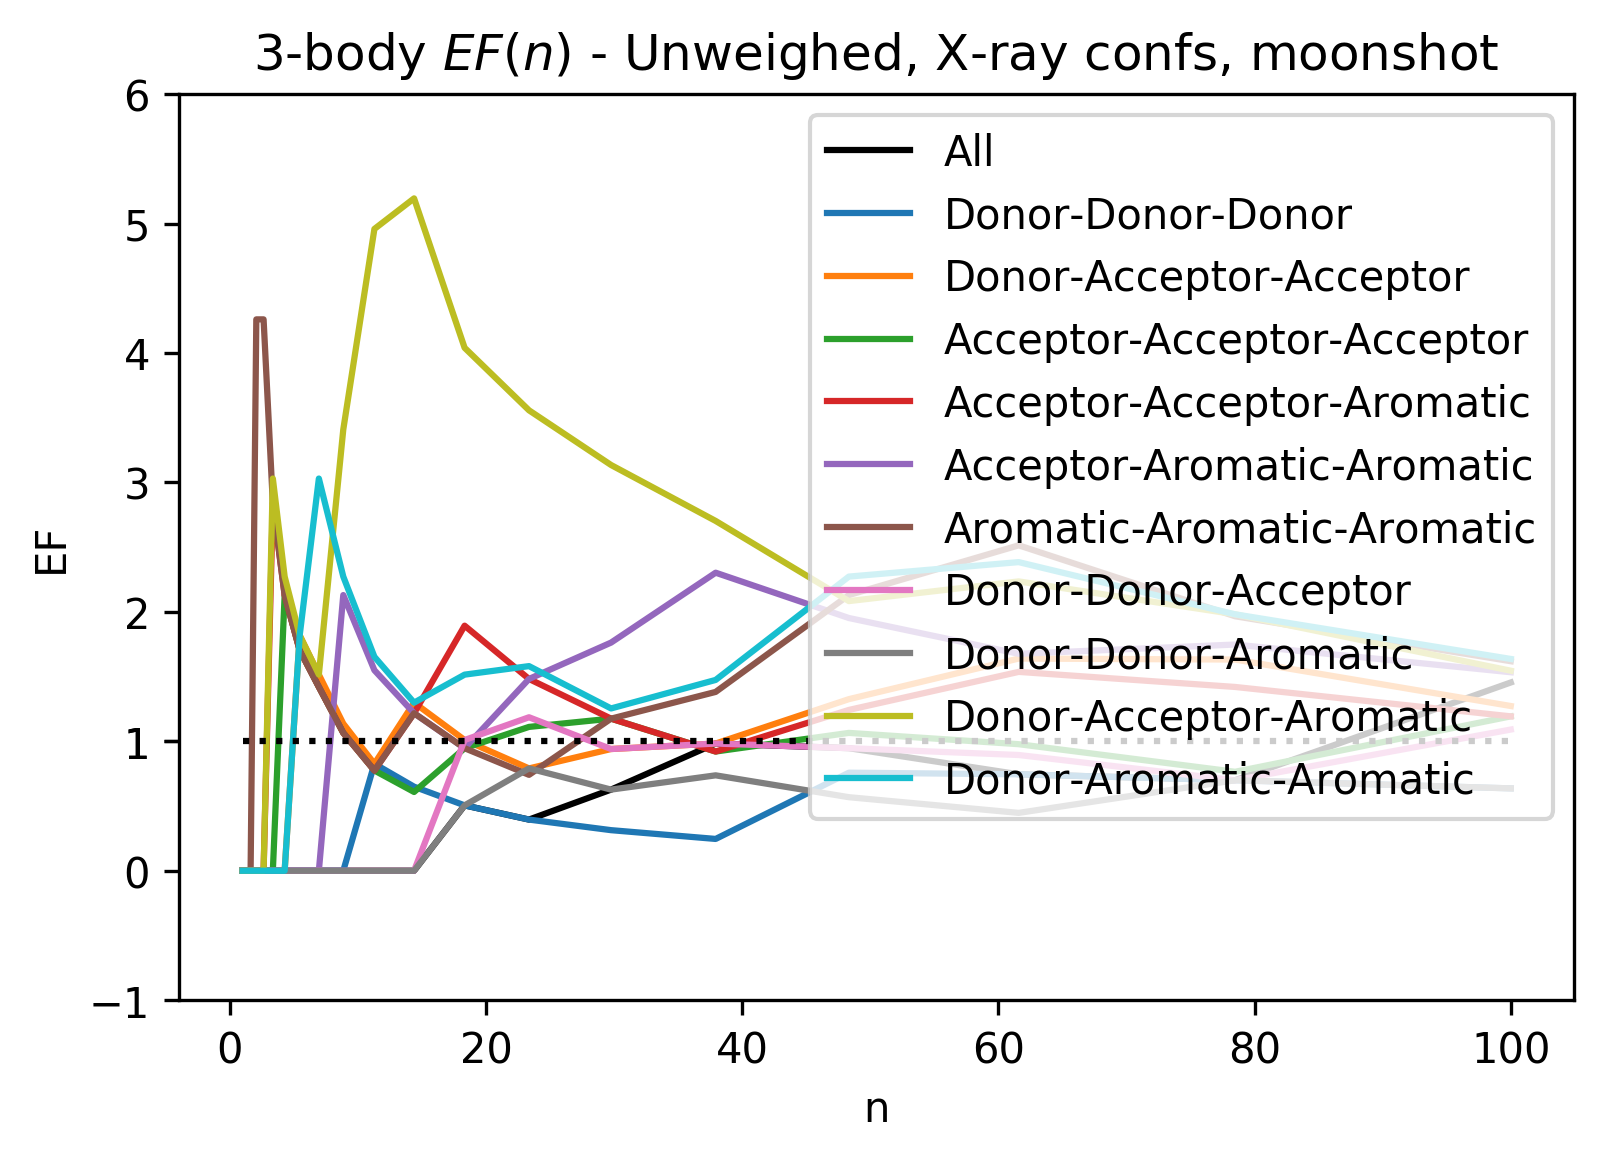

In [31]:
fig = plt.figure(dpi=300)
plt.plot(n_list, EF, 'k-', label='All')

for i, pcore in enumerate(important):

    final_hit_imp = hit_imp_trip[:,i]
    df1 = pd.DataFrame(list(zip(final_hit_imp, list(map(int, activity_list)))), columns = ['score','hit'])
    imp_df = df1
    imp_df.reset_index(inplace=True, drop=True)
    imp_df['hit'] = imp_df['hit'].astype('Int64').astype(bool)
    
    EF_imp = [enrichment(imp_df, n=int(n), index='hit') for n in n_list]
    plt.plot(n_list, EF_imp, label=pcore)

for i, pcore in enumerate(unimportant):

    final_hit_nonimp = hit_nonimp_trip[:,i]
    df1 = pd.DataFrame(list(zip(final_hit_nonimp, list(map(int, activity_list)))), columns = ['score','hit'])
    nonimp_df = df1
    nonimp_df.reset_index(inplace=True, drop=True)
    nonimp_df['hit'] = nonimp_df['hit'].astype('Int64').astype(bool)

    EF_nonimp = [enrichment(nonimp_df, n=int(n), index='hit') for n in n_list]
    plt.plot(n_list, EF_nonimp, label=pcore)

plt.title(r'3-body $EF(n)$ - Unweighed, X-ray confs, moonshot')
plt.legend()
plt.plot(n_list, np.ones_like(n_list), 'k:')

extraticks = [1]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.ylim(bottom=-1)
plt.xlabel('n')
plt.ylabel('EF')

### Fresh

orig proportion of hit: 11.000%
N = 1, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 11.000%
N = 1, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 11.000%
N = 1, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 11.000%
N = 2, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 11.000%
N = 2, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 11.000%
N = 3, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 11.000%
N = 4, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 11.000%
N = 5, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 11.000%
N = 6, n_hits = 0, new proportion of hit: 0.000%
orig proportion of hit: 11.000%
N = 8, n_hits = 1, new proportion of hit: 12.500%
orig proportion of hit: 11.000%
N = 11, n_hits = 1, new proportion of hit: 9.091%
orig proportion of hit: 11.000%
N = 14, n_hits = 1, new proportion of hit: 7.143%
orig proportion of hit: 1

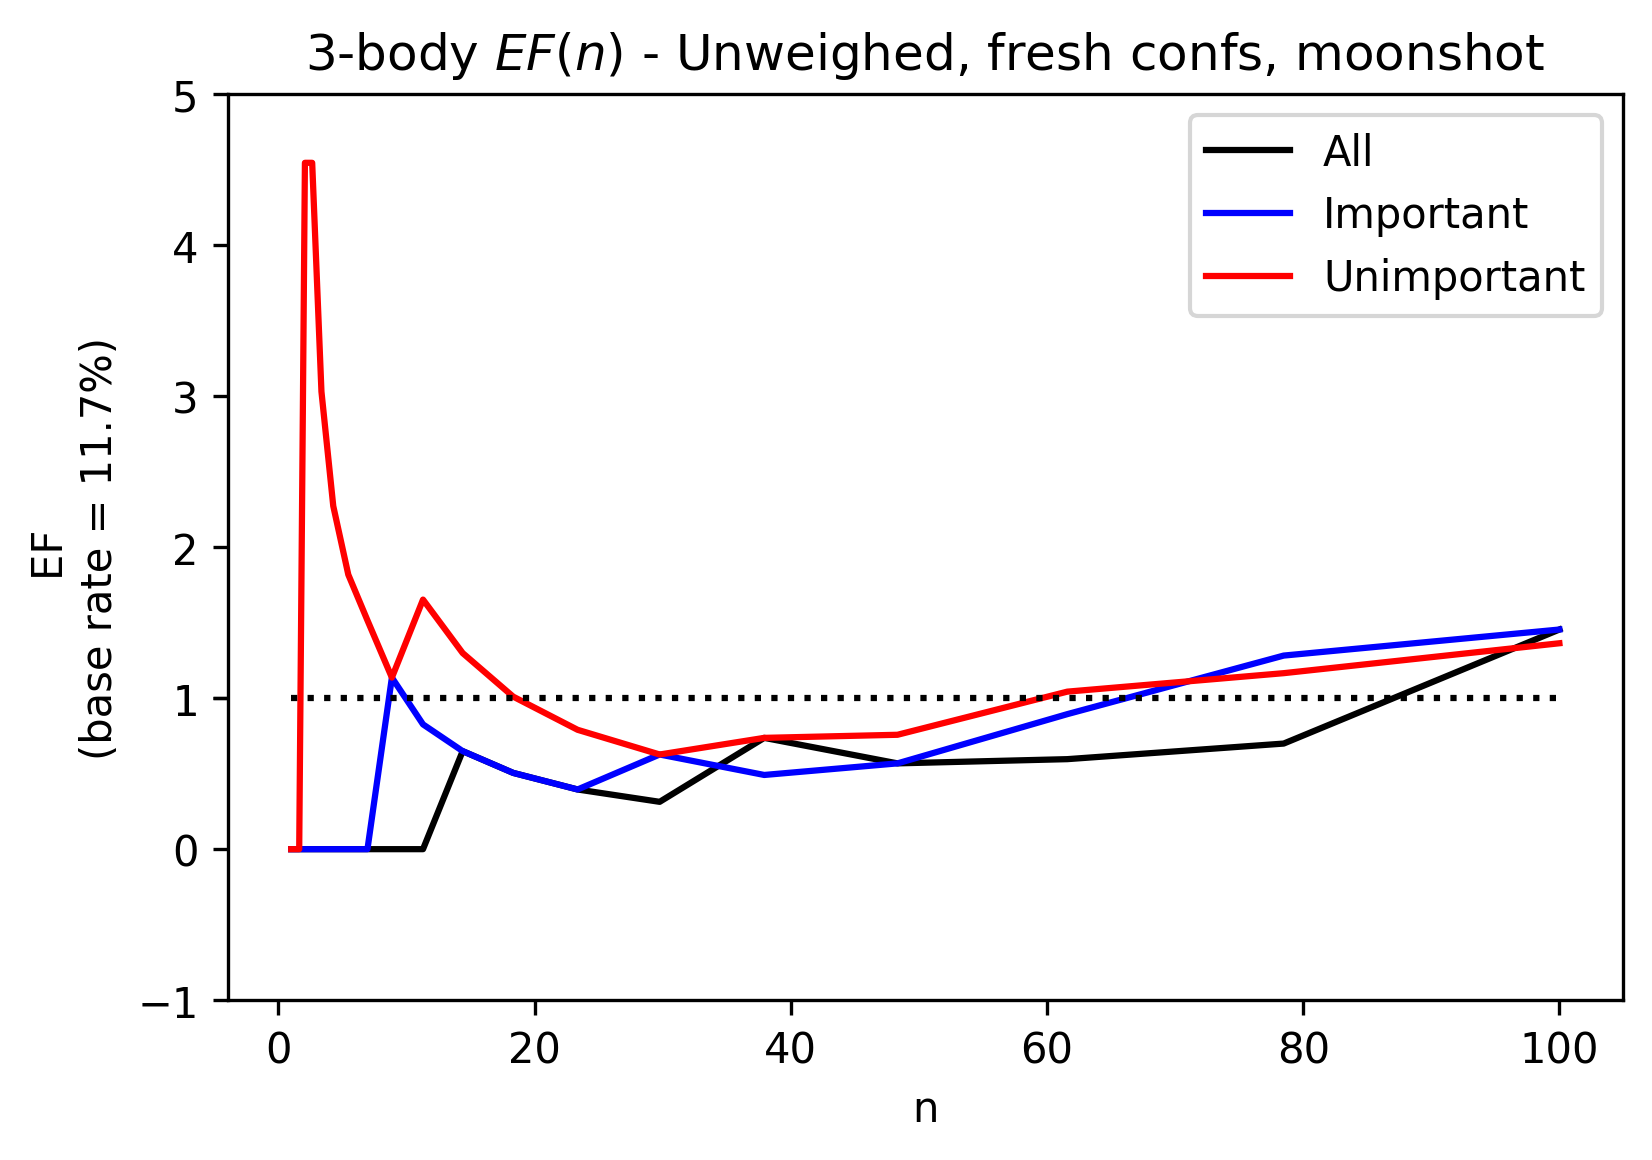

In [16]:
final_hit_imp = np.mean(hit_imp_trip, axis=1)

final_hit_nonimp = np.mean(hit_nonimp_trip, axis=1)

# df1 = pd.DataFrame(list(zip(final_hit_imp, np.ones_like(final_hit_imp))), columns = ['score','hit'])
df1 = pd.DataFrame(list(zip(final_hit_imp, list(map(int, activity_list)))), columns = ['score','hit'])
# df1 = df1[df1['hit']==1]
imp_df = df1
imp_df.reset_index(inplace=True, drop=True)
imp_df['hit'] = imp_df['hit'].astype('Int64').astype(bool)

# df1 = pd.DataFrame(list(zip(final_hit_nonimp, np.ones_like(final_hit_nonimp))), columns = ['score','hit'])
df1 = pd.DataFrame(list(zip(final_hit_nonimp, list(map(int, activity_list)))), columns = ['score','hit'])
# df1 = df1[df1['hit']==1]
nonimp_df = df1
nonimp_df.reset_index(inplace=True, drop=True)
nonimp_df['hit'] = nonimp_df['hit'].astype('Int64').astype(bool)

trip_df = imp_df.join(nonimp_df, lsuffix='_imp', rsuffix='_nonimp')
trip_df['score'] = trip_df['score_imp'] + trip_df['score_nonimp']

# n_list = np.logspace(start=1, stop=np.log10(len(df2)), num=50)
n_list = np.logspace(start=0, stop=2, num=20) # only check top 1000
EF = [enrichment(pair_df, n=int(n), index='hit_imp') for n in n_list]
EF_imp = [enrichment(imp_df, n=int(n), index='hit', log=True) for n in n_list]
# EF_imp = [enrichment(imp_df, n=int(n), index='hit') for n in n_list]
EF_nonimp = [enrichment(nonimp_df, n=int(n), index='hit') for n in n_list]

orig_prop = len(imp_df[imp_df['hit']])/len(imp_df)

fig = plt.figure(dpi=300)
plt.plot(n_list, EF, 'k-', label='All')
plt.plot(n_list, EF_imp, 'b-', label='Important')
plt.plot(n_list, EF_nonimp, 'r-', label='Unimportant')
# plt.title(r'Pair histogram $EF(n)$ - weighted by num points')
# plt.title(r'Pair histogram $EF(n)$ - Unweighed')
plt.title(r'3-body $EF(n)$ - Unweighed, fresh confs, moonshot')
# plt.xscale('log')
plt.legend()
plt.plot(n_list, np.ones_like(n_list), 'k:')
extraticks = [1]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.ylim(bottom=-1)
# plt.title(r'Pair histogram $EF(n)$ - shannon entropy * num points')
plt.xlabel('n')
plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
plt.show()

Text(0, 0.5, 'EF')

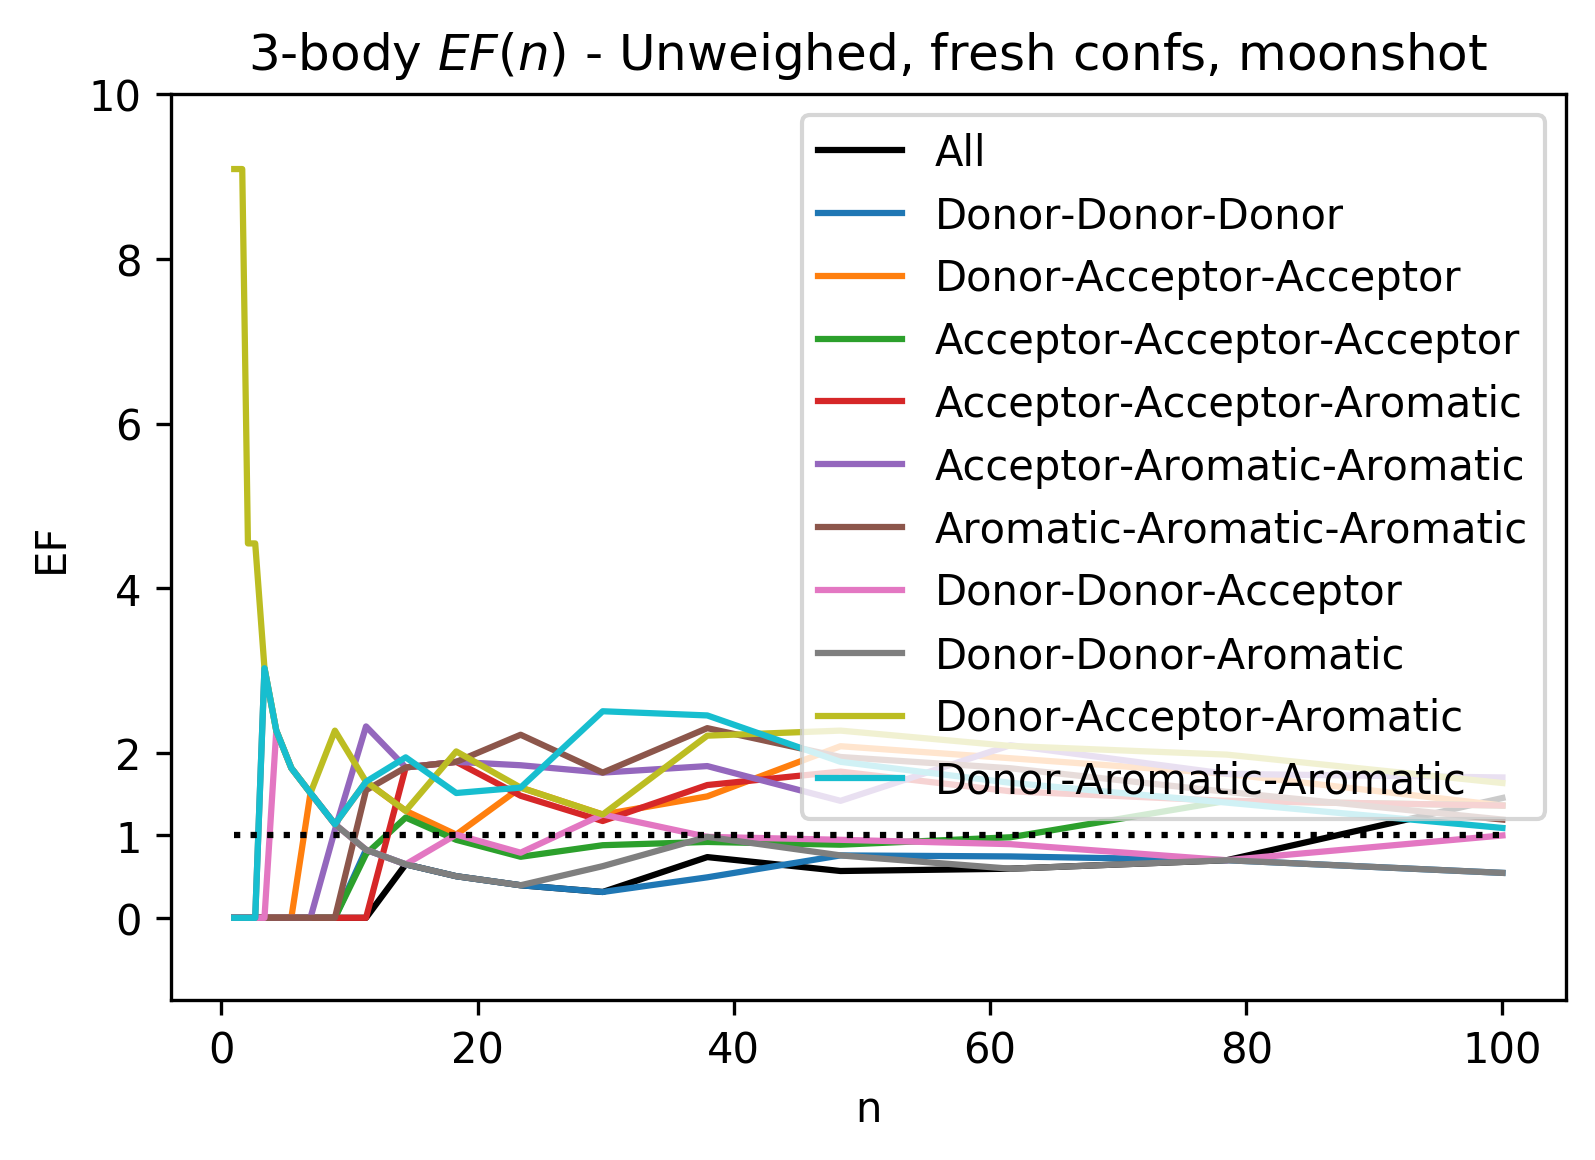

In [18]:
fig = plt.figure(dpi=300)
plt.plot(n_list, EF, 'k-', label='All')

for i, pcore in enumerate(important):

    final_hit_imp = hit_imp_trip[:,i]
    df1 = pd.DataFrame(list(zip(final_hit_imp, list(map(int, activity_list)))), columns = ['score','hit'])
    imp_df = df1
    imp_df.reset_index(inplace=True, drop=True)
    imp_df['hit'] = imp_df['hit'].astype('Int64').astype(bool)
    
    EF_imp = [enrichment(imp_df, n=int(n), index='hit') for n in n_list]
    plt.plot(n_list, EF_imp, label=pcore)

for i, pcore in enumerate(unimportant):

    final_hit_nonimp = hit_nonimp_trip[:,i]
    df1 = pd.DataFrame(list(zip(final_hit_nonimp, list(map(int, activity_list)))), columns = ['score','hit'])
    nonimp_df = df1
    nonimp_df.reset_index(inplace=True, drop=True)
    nonimp_df['hit'] = nonimp_df['hit'].astype('Int64').astype(bool)

    EF_nonimp = [enrichment(nonimp_df, n=int(n), index='hit') for n in n_list]
    plt.plot(n_list, EF_nonimp, label=pcore)

plt.title(r'3-body $EF(n)$ - Unweighed, fresh confs, moonshot')
plt.legend()
plt.plot(n_list, np.ones_like(n_list), 'k:')

extraticks = [1]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.ylim(bottom=-1)
plt.xlabel('n')
plt.ylabel('EF')

In [ ]:
# mix scoring

# pair_df = pair_df.reset_index()
# trip_df = trip_df.reset_index()
# score_df = pair_df.join(trip_df, lsuffix='_l', rsuffix='_r')
score_df = pair_df.merge(trip_df, how='inner', left_index=True, right_index=True)
score_df['score_y'] = np.power(score_df['score_y'], 0.33)
score_df['score_imp_y'] = np.power(score_df['score_imp_y'], 0.33)
score_df['score_nonimp_y'] = np.power(score_df['score_nonimp_y'], 0.33)

score_df['score'] = score_df['score_x'] + score_df['score_y']
score_df['score_imp'] = score_df['score_imp_x'] + score_df['score_imp_y']
score_df['score_nonimp'] = score_df['score_nonimp_x'] + score_df['score_nonimp_y']

EF = [enrichment(score_df, n=int(n), index='hit_imp_x') for n in n_list]
EF_imp = [enrichment(score_df, n=int(n), index='hit_imp_x', score='score_imp') for n in n_list]
EF_nonimp = [enrichment(score_df, n=int(n), index='hit_imp_x', score='score_nonimp') for n in n_list]

fig = plt.figure(dpi=300)
plt.plot(n_list, EF, 'k-', label='All')
plt.plot(n_list, EF_imp, 'b-', label='Important')
plt.plot(n_list, EF_nonimp, 'r-', label='Unimportant')
plt.title(r'2-body AND 3-body histogram $EF(n)$')
plt.legend()
plt.xlabel('n')
plt.ylabel('EF')
plt.show()